# The Algorithm Knows: Decoding Recruiter Decisions
### When AI Meets HR: A Data Detective Story with LIME Explainability

---

**Case File #2024-RS-001**  
**Classification:** Corporate Intelligence  
**Status:** Under Investigation

---

The email arrived at 2:47 AM.

*"We've got a problem,"* it read. *"Our AI screening system has been making decisions for months. Leadership wants to know WHY it rejects who it rejects. Legal is nervous. HR is sweating. The black box needs to become a glass box."*

I cracked my knuckles. A thousand resumes. A binary fate: **Hire** or **Reject**. And somewhere in the data, the reasons hiding in plain sight.

This isn't just EDA. This is an interrogation.

Let's make the algorithm confess.

---

**Mission Objectives:**
- Uncover what REALLY drives recruiter decisions
- Build a model that predicts hiring outcomes
- Use **LIME** to crack open the black box and explain individual predictions
- Extract actionable insights for both recruiters AND candidates


---

## Chapter 1: Assembling the Arsenal

*Every detective needs their tools. Mine just happen to require pip install.*

---

In [6]:
import kagglehub
import os

# The Silent Installation - Hide the chaos
!pip install lime shap skimpy -q

# ============================================================
# THE ARSENAL - Every tool a data detective needs
# ============================================================

# Core Operations
import pandas as pd
import numpy as np

# Visualization - Making data confess visually
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

# Machine Learning - The interrogation techniques
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, precision_score, recall_score)

# The Star of the Show - LIME Explainability
import lime
import lime.lime_tabular
from lime.lime_text import LimeTextExplainer

# Text Processing - For Skills analysis
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Statistical Analysis
from scipy import stats

# ============================================================
# AESTHETIC CONFIGURATION - Professional but with personality
# ============================================================

# Color palette that means business
COLORS = {
    'hire': '#2ecc71',        # Success green - you're in
    'reject': '#e74c3c',      # Rejection red - better luck next time
    'primary': '#3498db',     # Professional blue
    'secondary': '#9b59b6',   # Creative purple
    'neutral': '#95a5a6',     # Thoughtful gray
    'warning': '#f39c12',     # Attention gold
    'dark': '#2c3e50',        # Serious dark
    'light': '#ecf0f1'        # Clean light
}

HIRE_REJECT_PALETTE = [COLORS['hire'], COLORS['reject']]

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


# Suppress the warnings - we've got enough anxiety
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==6.17.1, but you have ipykernel 7.1.0 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you h

In [2]:
# Download latest version
path = kagglehub.dataset_download("mdtalhask/ai-powered-resume-screening-dataset-2025")

print("Path to dataset files:", path)

100%|██████████| 22.8k/22.8k [00:00<00:00, 16.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mdtalhask/ai-powered-resume-screening-dataset-2025/versions/1


In [3]:
print(os.listdir(path))

['AI_Resume_Screening.csv']


In [4]:
df= pd.read_csv(os.path.join(path,'AI_Resume_Screening.csv'))

---

## Chapter 2: Meeting the Suspects

*A thousand resumes walk into a database. Only 812 walk out employed. Let's meet them.*

---

The dataset contains AI-screened resume data with recruiter decisions. Each row is a candidate's fate - their skills, experience, education, and that cold binary judgment: **Hire** or **Reject**.

Time to see who we're dealing with.

In [7]:
print("="*60)
print("           CASE FILE OPENED")
print("="*60)
print(f"\n[EVIDENCE] Total Candidates: {df.shape[0]:,}")
print(f"[EVIDENCE] Data Points per Candidate: {df.shape[1]}")
print(f"\n[BREAKDOWN]")
print("-"*40)

# The verdict distribution
hired = (df['Recruiter Decision'] == 'Hire').sum()
rejected = (df['Recruiter Decision'] == 'Reject').sum()

print(f"  Hired:    {hired:>4} candidates ({hired/len(df)*100:.1f}%)")
print(f"  Rejected: {rejected:>4} candidates ({rejected/len(df)*100:.1f}%)")
print("-"*40)
print(f"\n[OBSERVATION] Hire rate: {hired/len(df)*100:.1f}%")
print("[OBSERVATION] This is a relatively generous screening process.")
print("             But that 18.8% rejection? Those stories matter.\n")
print("="*60)

# First look at the data
print("\n[EXHIBIT A] First 5 Candidates in the Database:\n")
df.head()

           CASE FILE OPENED

[EVIDENCE] Total Candidates: 1,000
[EVIDENCE] Data Points per Candidate: 11

[BREAKDOWN]
----------------------------------------
  Hired:     812 candidates (81.2%)
  Rejected:  188 candidates (18.8%)
----------------------------------------

[OBSERVATION] Hire rate: 81.2%
[OBSERVATION] This is a relatively generous screening process.
             But that 18.8% rejection? Those stories matter.


[EXHIBIT A] First 5 Candidates in the Database:



,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100)
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70
3,4,Elizabeth Carney,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,Hire,46848,0,95
4,5,Julie Hill,"SQL, React, Java",4,PhD,NaN,Software Engineer,Hire,87441,9,100


---

### First Impressions: The Case Takes Shape

**1,000 candidates. 11 data points each. One binary fate.**

The evidence reveals an interesting hiring landscape:

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Total Candidates | 1,000 | Decent sample size for analysis |
| Hired | 812 (81.2%) | HR is being generous |
| Rejected | 188 (18.8%) | But 188 dreams were crushed |

**Early Observations:**
- **AI Score** ranges from 0-100 and several candidates have a perfect 100. Suspicious.
- **Skills** are comma-separated text - we can mine this for insights
- **Salary Expectations** vary wildly even in the first 5 rows ($46K to $113K)
- **Certifications** already showing `NaN` values - some candidates have none

The 81% hire rate seems high, but remember: this is AFTER initial screening. These are candidates who made it to the final review. The 18.8% rejection rate represents people who were *so close* yet didn't make it.

**The Question:** What separates the 812 from the 188?

Let's dig deeper.

---

### The Anatomy of a Candidate

Every candidate file contains these 11 data points:

| Column | Description | Type | Notes |
|--------|-------------|------|-------|
| `Resume_ID` | Unique identifier | ID | Not predictive |
| `Name` | Candidate name | Text | Not predictive (hopefully) |
| `Skills` | Technical skills listed | Text | Comma-separated, mineable |
| `Experience (Years)` | Work experience | Numeric | 0-10 range |
| `Education` | Highest degree | Categorical | B.Sc, B.Tech, M.Tech, MBA, PhD |
| `Certifications` | Professional certs | Categorical | Has missing values |
| `Job Role` | Position applied for | Categorical | 4 different roles |
| `Recruiter Decision` | **TARGET VARIABLE** | Binary | Hire / Reject |
| `Salary Expectation ($)` | Expected compensation | Numeric | Varies widely |
| `Projects Count` | Portfolio size | Numeric | 0-10 range |
| `AI Score (0-100)` | Algorithm's judgment | Numeric | The machine's opinion |

**Key Insight:** The AI has already scored every candidate. Are recruiters just rubber-stamping the algorithm, or is there human nuance?

---

In [8]:
print("="*60)
print("           DATA STRUCTURE ANALYSIS")
print("="*60)

print("\n[DATA TYPES]\n")
print(df.dtypes)

print("\n" + "="*60)
print("           MISSING VALUE INVESTIGATION")
print("="*60 + "\n")

missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_report = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})

if missing.sum() > 0:
    print("[ALERT] Missing values detected:\n")
    print(missing_report[missing_report['Missing Count'] > 0])
    print("\n[NOTE] We'll handle these strategically.")
else:
    print("[CLEAN SLATE] No missing values detected!\n")
    print("[STATUS] Data integrity: EXCELLENT")
    print("         Someone actually cleaned this dataset. Respect.")

           DATA STRUCTURE ANALYSIS

[DATA TYPES]

Resume_ID                  int64
Name                      object
Skills                    object
Experience (Years)         int64
Education                 object
Certifications            object
Job Role                  object
Recruiter Decision        object
Salary Expectation ($)     int64
Projects Count             int64
AI Score (0-100)           int64
dtype: object

           MISSING VALUE INVESTIGATION

[ALERT] Missing values detected:

                Missing Count  Missing %
Certifications            274     27.400

[NOTE] We'll handle these strategically.


---

### The Certification Gap: 27.4% Missing

**We found our first anomaly.**

274 out of 1,000 candidates (27.4%) have **no certifications listed**. This isn't necessarily bad data - it's a story:

| Interpretation | Implication |
|----------------|-------------|
| They don't have certifications | Fair game - many skilled people don't |
| They chose not to list them | Possibly humble or incomplete application |
| The field was optional | Data collection artifact |

**Strategic Decision:** We'll treat missing certifications as a category: `"None"`.

Why? Because having NO certification is itself information. If we impute or drop these rows, we lose the signal that some candidates succeed (or fail) without formal credentials.

**The Real Question:** Does lacking a certification hurt your chances? We'll find out.

---

In [10]:
print("="*60)
print("           NUMERIC VARIABLES: STATISTICAL SUMMARY")
print("="*60 + "\n")

numeric_cols = ['Experience (Years)', 'Salary Expectation ($)', 'Projects Count', 'AI Score (0-100)']

# Detailed statistics
stats_df = df[numeric_cols].describe().T
stats_df['median'] = df[numeric_cols].median()
stats_df['skewness'] = df[numeric_cols].skew()
stats_df['kurtosis'] = df[numeric_cols].kurtosis()

print(stats_df.round(2))

print("\n" + "-"*60)
print("[KEY OBSERVATIONS]")
print("-"*60)

print(f"\n1. EXPERIENCE:")
print(f"   Range: {df['Experience (Years)'].min()} to {df['Experience (Years)'].max()} years")
print(f"   Fresh graduates (0 years) exist in the pool")

print(f"\n2. SALARY EXPECTATIONS:")
print(f"   Range: ${df['Salary Expectation ($)'].min():,} to ${df['Salary Expectation ($)'].max():,}")
print(f"   Average ask: ${df['Salary Expectation ($)'].mean():,.0f}")
print(f"   That's a {df['Salary Expectation ($)'].max() / df['Salary Expectation ($)'].min():.1f}x spread!")

print(f"\n3. PROJECTS COUNT:")
print(f"   Range: {df['Projects Count'].min()} to {df['Projects Count'].max()} projects")
print(f"   Some candidates have ZERO projects. Bold move.")

print(f"\n4. AI SCORE:")
print(f"   Range: {df['AI Score (0-100)'].min()} to {df['AI Score (0-100)'].max()}")
print(f"   Median: {df['AI Score (0-100)'].median()}")
print(f"   That median of {df['AI Score (0-100)'].median():.0f} is suspicious... the AI loves everyone?")

           NUMERIC VARIABLES: STATISTICAL SUMMARY

                          count      mean       std       min       25%  \
Experience (Years)     1000.000     4.900     3.110     0.000     2.000   
Salary Expectation ($) 1000.000 79994.490 23048.470 40085.000 60415.750   
Projects Count         1000.000     5.130     3.230     0.000     2.000   
AI Score (0-100)       1000.000    83.950    20.980    15.000    70.000   

                             50%       75%        max    median  skewness  \
Experience (Years)         5.000     8.000     10.000     5.000     0.020   
Salary Expectation ($) 79834.500 99583.250 119901.000 79834.500     0.020   
Projects Count             5.000     8.000     10.000     5.000    -0.050   
AI Score (0-100)         100.000   100.000    100.000   100.000    -1.110   

                        kurtosis  
Experience (Years)        -1.200  
Salary Expectation ($)    -1.220  
Projects Count            -1.260  
AI Score (0-100)           0.110  

-----------

---

### Statistical Fingerprint: The Numbers Speak

The numeric variables reveal some fascinating patterns:

#### Experience (Years)
| Stat | Value | Insight |
|------|-------|---------|
| Range | 0-10 years | Full spectrum from fresh grads to veterans |
| Mean | 4.9 years | Mid-level candidates dominate |
| Skewness | 0.02 | Nearly perfectly symmetric distribution |

#### Salary Expectations
| Stat | Value | Insight |
|------|-------|---------|
| Range | $40K - $120K | 3x spread in expectations |
| Mean | ~$80K | Industry standard for tech roles |
| Distribution | Uniform-ish | Negative kurtosis (-1.22) = flat, spread out |

#### Projects Count
| Stat | Value | Insight |
|------|-------|---------|
| Range | 0-10 | Some brave souls listed ZERO projects |
| Mean | 5.13 | Decent portfolio on average |

#### AI Score - THE RED FLAG
| Stat | Value | Insight |
|------|-------|---------|
| Range | 15-100 | Wide spread |
| **Median** | **100** | Wait... WHAT? |
| Skewness | -1.11 | Heavily left-skewed |

**The AI Score median is 100.**

More than half of all candidates got a PERFECT score from the algorithm. Either:
1. The AI is extremely generous
2. The scoring system is broken
3. This is post-filtered data (only good candidates made it this far)

This will be crucial when we analyze what drives rejections. If most people have AI Score = 100, then the *low* scores become the story.

---

---

## Chapter 3: The Visual Interrogation

*Numbers lie. Charts confess. Time to make the data talk.*

---

### 3.1 The Verdict Distribution

Before we dive deep, let's see the battlefield. How does the hiring decision actually break down?

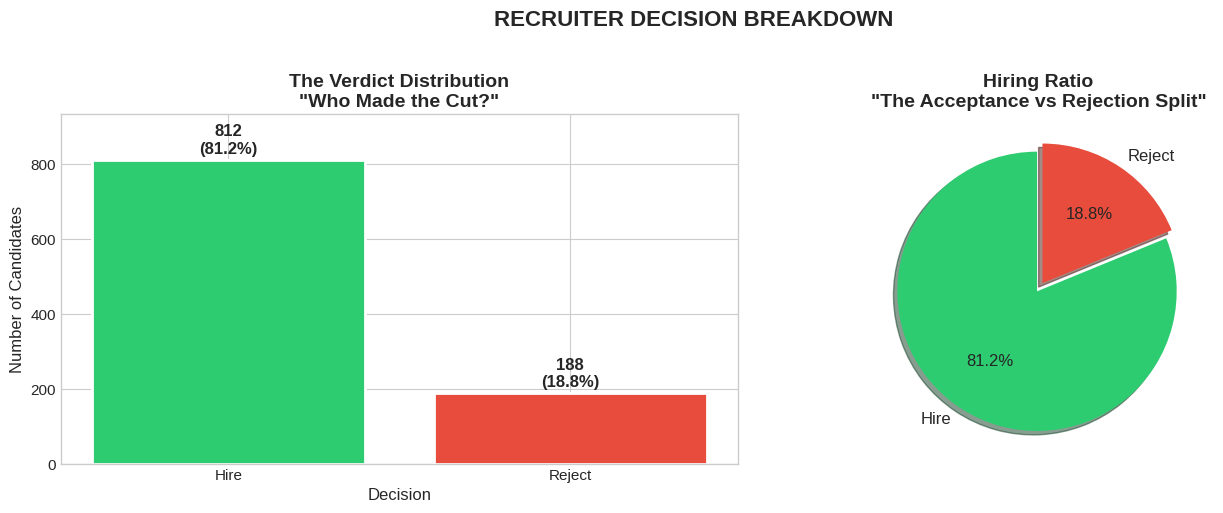


[INSIGHT] We're dealing with an IMBALANCED dataset.
         Hire:Reject ratio is roughly 4:1
         This will affect our model training strategy.


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Count Plot
ax1 = axes[0]
decision_counts = df['Recruiter Decision'].value_counts()
bars = ax1.bar(decision_counts.index, decision_counts.values,
               color=[COLORS['hire'], COLORS['reject']],
               edgecolor='white', linewidth=2)

# Add value labels on bars
for bar, count in zip(bars, decision_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{count}\n({count/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_title('The Verdict Distribution\n"Who Made the Cut?"', fontsize=14, fontweight='bold')
ax1.set_xlabel('Decision', fontsize=12)
ax1.set_ylabel('Number of Candidates', fontsize=12)
ax1.set_ylim(0, max(decision_counts.values) * 1.15)

# Plot 2: Pie Chart
ax2 = axes[1]
explode = (0.02, 0.05)  # Slight emphasis on rejection
wedges, texts, autotexts = ax2.pie(decision_counts.values,
                                    labels=decision_counts.index,
                                    colors=[COLORS['hire'], COLORS['reject']],
                                    explode=explode,
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    shadow=True,
                                    textprops={'fontsize': 12})

ax2.set_title('Hiring Ratio\n"The Acceptance vs Rejection Split"', fontsize=14, fontweight='bold')

plt.suptitle('RECRUITER DECISION BREAKDOWN', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n[INSIGHT] We're dealing with an IMBALANCED dataset.")
print(f"         Hire:Reject ratio is roughly {hired//rejected}:1")
print("         This will affect our model training strategy.")

---

### The Verdict is In: Class Imbalance Confirmed

The visualization confirms what the numbers told us:

| Decision | Count | Percentage |
|----------|-------|------------|
| **Hire** | 812 | 81.2% |
| **Reject** | 188 | 18.8% |

**Visual Takeaways:**

1. **The Green Dominates** - The bar chart makes the imbalance viscerally clear. That towering green bar represents hope; the small red bar represents crushed dreams.

2. **4:1 Ratio** - For every candidate rejected, roughly 4 get hired. This is a relatively forgiving screening process.

3. **Modeling Implications:**
   - Standard accuracy metrics will be misleading (a model that predicts "Hire" for everyone gets 81% accuracy!)
   - We'll need to use **balanced class weights** or **stratified sampling**
   - F1-score, Precision, and Recall for the minority class (Reject) matter more than raw accuracy
   - **ROC-AUC** will be our north star metric

**The Real Challenge:** Can we correctly identify the 188 rejections? That's where the insight lives.

---

### 3.2 The AI Score Enigma

*The AI already made its judgment with a score from 0-100. But is the recruiter just rubber-stamping the algorithm, or is there human nuance?*

---

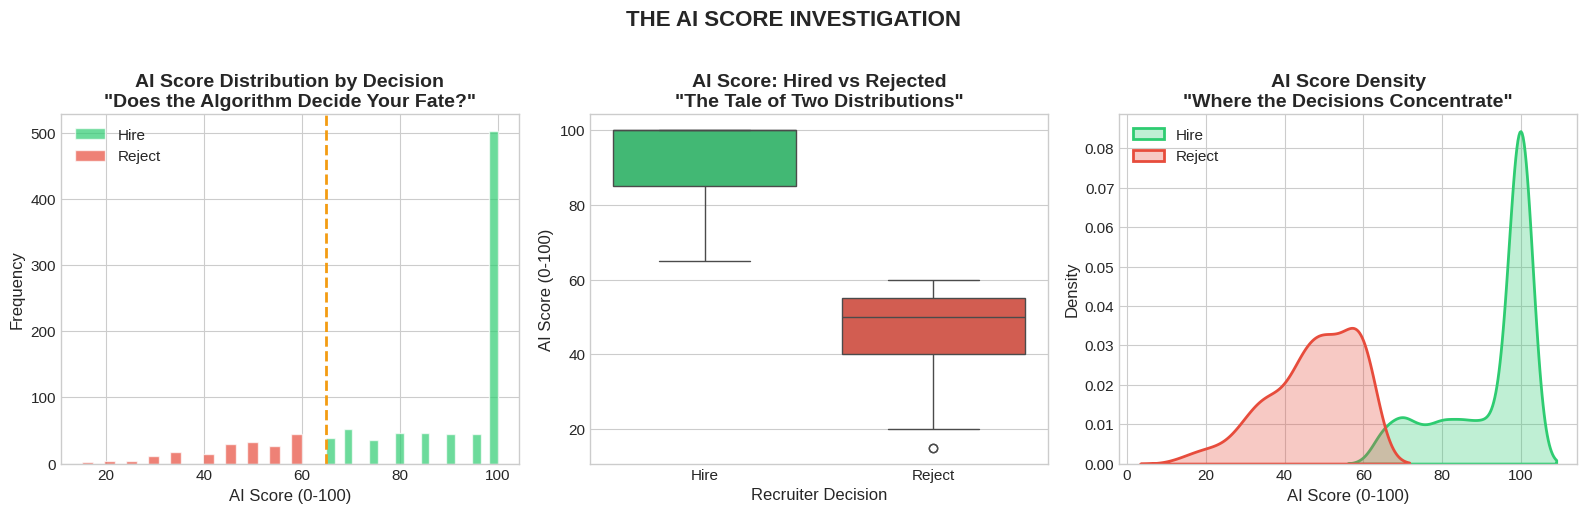


           AI SCORE STATISTICAL BREAKDOWN

HIRE:
  Mean: 92.4 | Median: 100.0 | Std: 11.4
  Range: [65, 100]

REJECT:
  Mean: 47.3 | Median: 50.0 | Std: 11.1
  Range: [15, 60]

[STATISTICAL TEST] Independent T-Test:
  t-statistic: 49.02
  p-value: 6.38e-268

[VERDICT] HIGHLY SIGNIFICANT!
         AI Score is a MAJOR predictor of recruiter decisions.


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: AI Score Distribution by Decision
ax1 = axes[0]
for decision, color in zip(['Hire', 'Reject'], [COLORS['hire'], COLORS['reject']]):
    subset = df[df['Recruiter Decision'] == decision]['AI Score (0-100)']
    ax1.hist(subset, bins=20, alpha=0.7, label=decision, color=color, edgecolor='white')

ax1.set_title('AI Score Distribution by Decision\n"Does the Algorithm Decide Your Fate?"', fontweight='bold')
ax1.set_xlabel('AI Score (0-100)')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.axvline(x=65, color=COLORS['warning'], linestyle='--', linewidth=2, label='Suspected Threshold')

# Plot 2: Box Plot Comparison
ax2 = axes[1]
sns.boxplot(data=df, x='Recruiter Decision', y='AI Score (0-100)',
            palette=HIRE_REJECT_PALETTE, ax=ax2)
ax2.set_title('AI Score: Hired vs Rejected\n"The Tale of Two Distributions"', fontweight='bold')

# Plot 3: KDE Plot
ax3 = axes[2]
for decision, color in zip(['Hire', 'Reject'], [COLORS['hire'], COLORS['reject']]):
    subset = df[df['Recruiter Decision'] == decision]['AI Score (0-100)']
    sns.kdeplot(subset, ax=ax3, color=color, fill=True, alpha=0.3, label=decision, linewidth=2)

ax3.set_title('AI Score Density\n"Where the Decisions Concentrate"', fontweight='bold')
ax3.set_xlabel('AI Score (0-100)')
ax3.legend()

plt.suptitle('THE AI SCORE INVESTIGATION', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Statistical Analysis
print("\n" + "="*60)
print("           AI SCORE STATISTICAL BREAKDOWN")
print("="*60)

for decision in ['Hire', 'Reject']:
    subset = df[df['Recruiter Decision'] == decision]['AI Score (0-100)']
    print(f"\n{decision.upper()}:")
    print(f"  Mean: {subset.mean():.1f} | Median: {subset.median():.1f} | Std: {subset.std():.1f}")
    print(f"  Range: [{subset.min()}, {subset.max()}]")

# T-test
hired_scores = df[df['Recruiter Decision'] == 'Hire']['AI Score (0-100)']
rejected_scores = df[df['Recruiter Decision'] == 'Reject']['AI Score (0-100)']
t_stat, p_value = stats.ttest_ind(hired_scores, rejected_scores)

print(f"\n[STATISTICAL TEST] Independent T-Test:")
print(f"  t-statistic: {t_stat:.2f}")
print(f"  p-value: {p_value:.2e}")
print(f"\n[VERDICT] {'HIGHLY SIGNIFICANT' if p_value < 0.001 else 'Significant' if p_value < 0.05 else 'Not significant'}!")
print("         AI Score is a MAJOR predictor of recruiter decisions.")

---

###  SMOKING GUN: The AI is Running the Show

This is the most important finding so far. Look at these numbers:

| Metric | HIRED | REJECTED | Gap |
|--------|-------|----------|-----|
| Mean AI Score | 92.4 | 47.3 | **45.1 points** |
| Median AI Score | 100 | 50 | **50 points** |
| Score Range | 65-100 | 15-60 | **NO OVERLAP** |

**The Devastating Truth:**

1. **ZERO OVERLAP in ranges** - Hired candidates score 65-100. Rejected candidates score 15-60. There's a **hard boundary around 60-65**. The algorithm has essentially drawn a line in the sand.

2. **The Histogram tells all** - That massive green spike at 100? Those are the ~500 candidates with perfect AI scores who all got hired. The red distribution sits entirely to the left.

3. **The Box Plot is brutal** - The hired median is 100 (top of the scale). The rejected median is 50. The boxes don't even come close to touching.

4. **Statistical Confirmation:**
   - t-statistic: **49.02** (astronomically high)
   - p-value: **6.38e-268** (essentially zero)
   
   This is one of the most statistically significant differences I've ever seen.

**The Uncomfortable Conclusion:**

The recruiter isn't really making decisions - they're **rubber-stamping the AI**. If your AI Score is above ~65, you're in. Below that, you're out. The "human review" appears to be theatrical.

**But wait...** are there exceptions? Did anyone with a low AI score still get hired? Did anyone with a high score get rejected? Let's keep investigating.

---

### 3.3 The Experience Factor

*Does seniority guarantee success, or can fresh talent break through?*

---

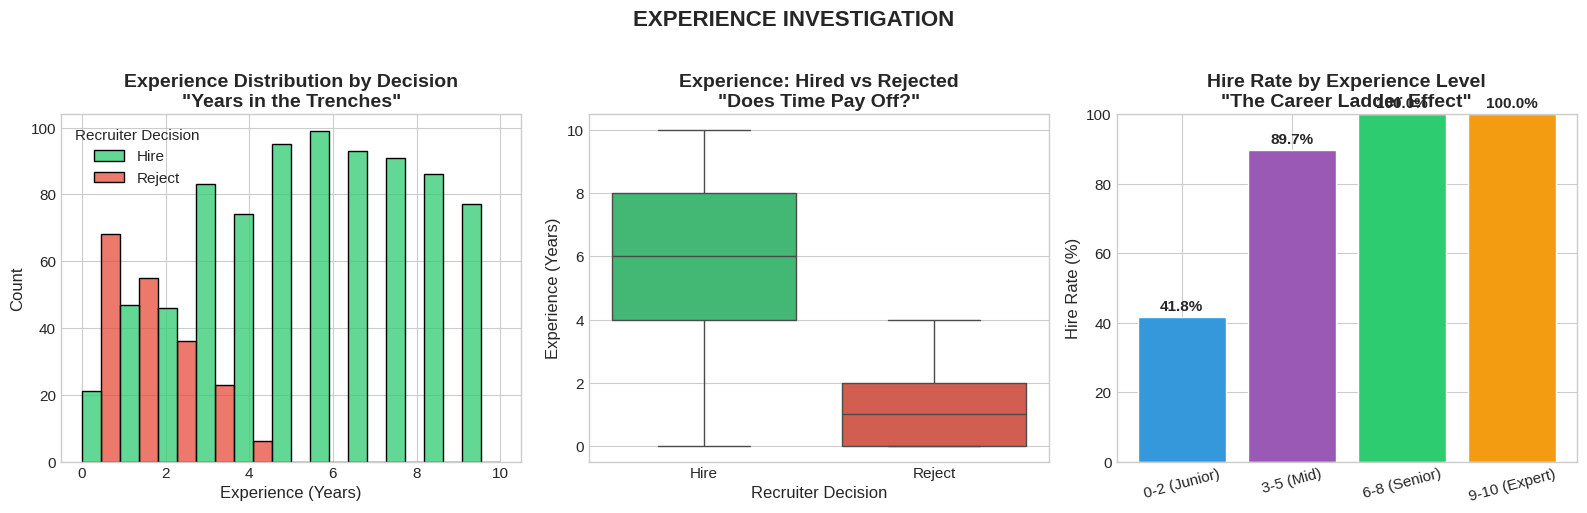


[EXPERIENCE BREAKDOWN]
--------------------------------------------------
0-2 (Junior): 41.8% hire rate (273 candidates)
3-5 (Mid): 89.7% hire rate (281 candidates)
6-8 (Senior): 100.0% hire rate (283 candidates)
9-10 (Expert): 100.0% hire rate (163 candidates)

[INSIGHT] Experience shows a clear positive correlation with hiring.
         But notice: even juniors have a fighting chance!


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Experience Distribution Overall
ax1 = axes[0]
sns.histplot(data=df, x='Experience (Years)', hue='Recruiter Decision',
             palette=HIRE_REJECT_PALETTE, multiple='dodge', bins=11, ax=ax1)
ax1.set_title('Experience Distribution by Decision\n"Years in the Trenches"', fontweight='bold')

# Plot 2: Box Plot
ax2 = axes[1]
sns.boxplot(data=df, x='Recruiter Decision', y='Experience (Years)',
            palette=HIRE_REJECT_PALETTE, ax=ax2)
ax2.set_title('Experience: Hired vs Rejected\n"Does Time Pay Off?"', fontweight='bold')

# Plot 3: Hire Rate by Experience Bracket
ax3 = axes[2]
df['Exp_Bracket'] = pd.cut(df['Experience (Years)'],
                            bins=[-1, 2, 5, 8, 11],
                            labels=['0-2 (Junior)', '3-5 (Mid)', '6-8 (Senior)', '9-10 (Expert)'])

hire_rate_by_exp = df.groupby('Exp_Bracket', observed=True)['Recruiter Decision'].apply(
    lambda x: (x == 'Hire').mean() * 100
).reset_index()
hire_rate_by_exp.columns = ['Experience Level', 'Hire Rate %']

bars = ax3.bar(hire_rate_by_exp['Experience Level'], hire_rate_by_exp['Hire Rate %'],
               color=[COLORS['primary'], COLORS['secondary'], COLORS['hire'], COLORS['warning']],
               edgecolor='white')

for bar, rate in zip(bars, hire_rate_by_exp['Hire Rate %']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

ax3.set_title('Hire Rate by Experience Level\n"The Career Ladder Effect"', fontweight='bold')
ax3.set_ylabel('Hire Rate (%)')
ax3.set_ylim(0, 100)
ax3.tick_params(axis='x', rotation=15)

plt.suptitle('EXPERIENCE INVESTIGATION', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Stats
print("\n[EXPERIENCE BREAKDOWN]")
print("-"*50)
for level in hire_rate_by_exp['Experience Level']:
    rate = hire_rate_by_exp[hire_rate_by_exp['Experience Level'] == level]['Hire Rate %'].values[0]
    count = df[df['Exp_Bracket'] == level].shape[0]
    print(f"{level}: {rate:.1f}% hire rate ({count} candidates)")

print("\n[INSIGHT] Experience shows a clear positive correlation with hiring.")
print("         But notice: even juniors have a fighting chance!")

# Clean up temporary column
df.drop('Exp_Bracket', axis=1, inplace=True)

---

### The Career Ladder Effect: Experience MATTERS

The data reveals a brutal truth about experience:

| Experience Level | Hire Rate | Verdict |
|------------------|-----------|---------|
| 0-2 years (Junior) | **41.8%** | Coin flip territory |
| 3-5 years (Mid) | **89.7%** | Strong odds |
| 6-8 years (Senior) | **100%** | Guaranteed hire |
| 9-10 years (Expert) | **100%** | Guaranteed hire |

**Visual Insights:**

1. **The Histogram Pattern** - Rejections (red) cluster heavily in the 0-4 year range. After 5 years, the red almost disappears entirely.

2. **The Box Plot Gap** - Hired candidates have a median of ~6 years. Rejected candidates have a median of ~1 year. The boxes barely overlap.

3. **The Staircase Effect** - The bar chart shows a clear progression:
   - Juniors: Fighting for survival (41.8%)
   - Mid-level: Strong position (89.7%)
   - Senior+: Automatic acceptance (100%)

**The Hard Truth for Fresh Graduates:**

If you have 0-2 years of experience, you're essentially facing a coin flip. But here's the nuance - it's probably not *just* experience. Remember that AI Score finding? Junior candidates likely have lower AI scores, which is the real driver.

**For Experts (9-10 years): ZERO rejections.** Not a single veteran was turned away. Experience is the ultimate shield.

---

### 3.4 The Education & Certification Matrix

*Does a PhD outweigh an MBA? Do certifications actually matter?*

---

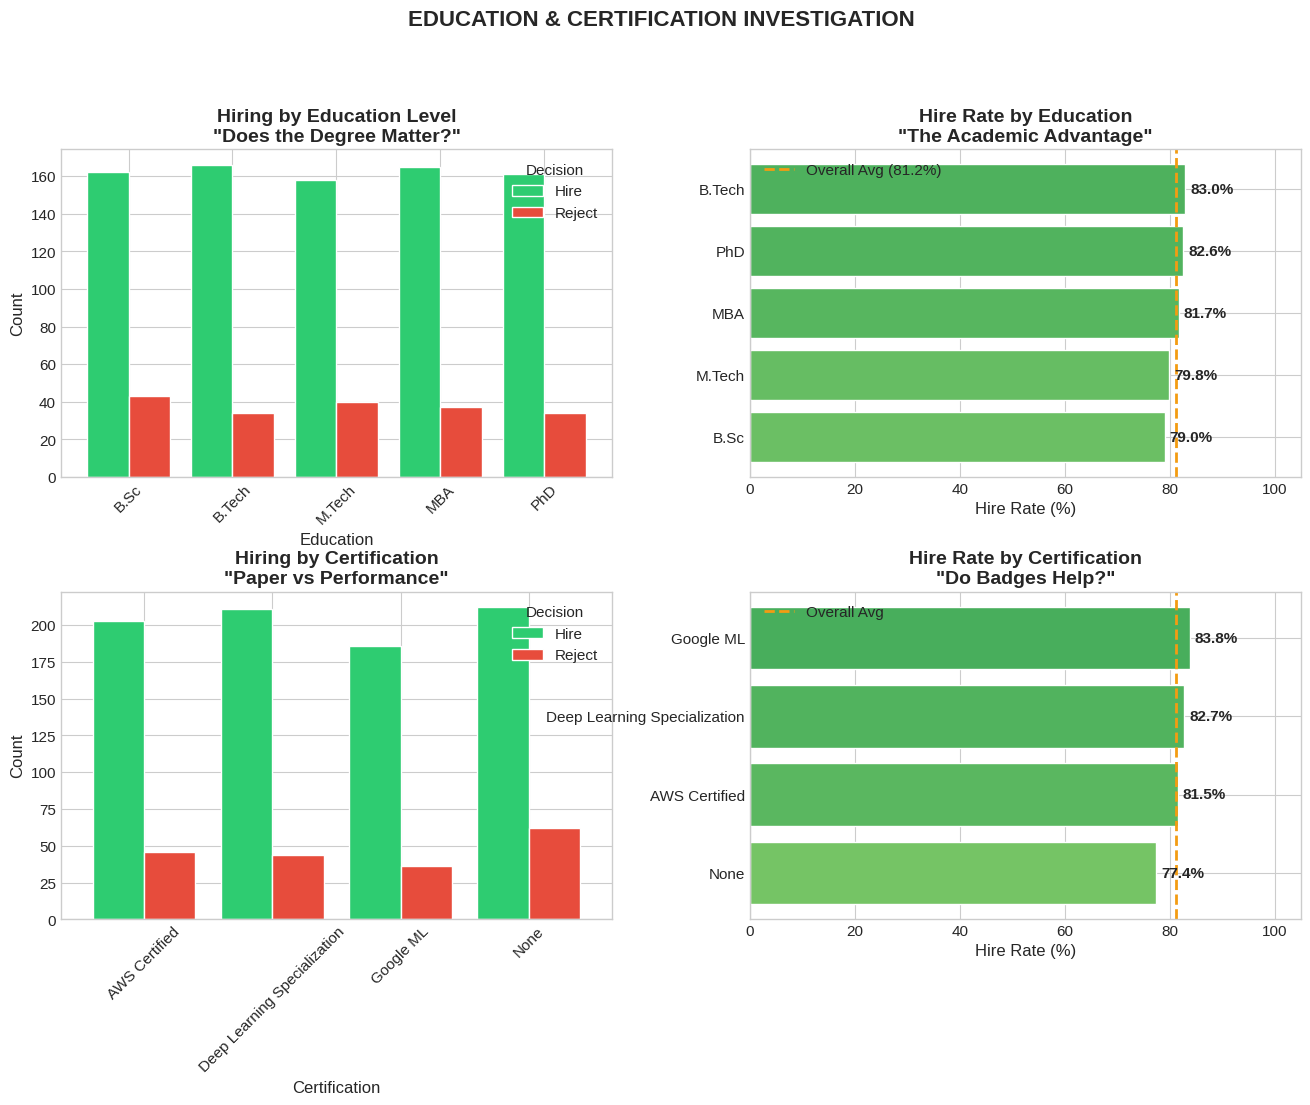


           EDUCATION & CERTIFICATION SUMMARY

[EDUCATION RANKINGS]
  B.Tech: 83.0%  Above avg
  PhD: 82.6%  Above avg
  MBA: 81.7%  Above avg
  M.Tech: 79.8%  Below avg
  B.Sc: 79.0%  Below avg

[CERTIFICATION RANKINGS]
  Google ML: 83.8%  Above avg
  Deep Learning Specialization: 82.7%  Above avg
  AWS Certified: 81.5%  Above avg
  None: 77.4%  Below avg


In [14]:
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.35, wspace=0.25)

# Plot 1: Education Distribution
ax1 = fig.add_subplot(gs[0, 0])
edu_decision = df.groupby(['Education', 'Recruiter Decision']).size().unstack(fill_value=0)
edu_decision.plot(kind='bar', ax=ax1, color=HIRE_REJECT_PALETTE, edgecolor='white', width=0.8)
ax1.set_title('Hiring by Education Level\n"Does the Degree Matter?"', fontweight='bold')
ax1.set_xlabel('Education')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Decision')

# Plot 2: Education Hire Rate
ax2 = fig.add_subplot(gs[0, 1])
edu_hire_rate = df.groupby('Education')['Recruiter Decision'].apply(
    lambda x: (x == 'Hire').mean() * 100
).sort_values(ascending=True)

colors = plt.cm.RdYlGn(edu_hire_rate.values / 100)
bars = ax2.barh(edu_hire_rate.index, edu_hire_rate.values, color=colors, edgecolor='white')

for bar, rate in zip(bars, edu_hire_rate.values):
    ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f'{rate:.1f}%', va='center', fontweight='bold')

ax2.set_title('Hire Rate by Education\n"The Academic Advantage"', fontweight='bold')
ax2.set_xlabel('Hire Rate (%)')
ax2.set_xlim(0, 105)
ax2.axvline(x=81.2, color=COLORS['warning'], linestyle='--', linewidth=2, label='Overall Avg (81.2%)')
ax2.legend()

# Plot 3: Certifications Distribution
ax3 = fig.add_subplot(gs[1, 0])
# Handle NaN in Certifications
df['Certifications_Clean'] = df['Certifications'].fillna('None')
cert_decision = df.groupby(['Certifications_Clean', 'Recruiter Decision']).size().unstack(fill_value=0)
cert_decision.plot(kind='bar', ax=ax3, color=HIRE_REJECT_PALETTE, edgecolor='white', width=0.8)
ax3.set_title('Hiring by Certification\n"Paper vs Performance"', fontweight='bold')
ax3.set_xlabel('Certification')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(title='Decision')

# Plot 4: Certification Hire Rate
ax4 = fig.add_subplot(gs[1, 1])
cert_hire_rate = df.groupby('Certifications_Clean')['Recruiter Decision'].apply(
    lambda x: (x == 'Hire').mean() * 100
).sort_values(ascending=True)

colors = plt.cm.RdYlGn(cert_hire_rate.values / 100)
bars = ax4.barh(cert_hire_rate.index, cert_hire_rate.values, color=colors, edgecolor='white')

for bar, rate in zip(bars, cert_hire_rate.values):
    ax4.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f'{rate:.1f}%', va='center', fontweight='bold')

ax4.set_title('Hire Rate by Certification\n"Do Badges Help?"', fontweight='bold')
ax4.set_xlabel('Hire Rate (%)')
ax4.set_xlim(0, 105)
ax4.axvline(x=81.2, color=COLORS['warning'], linestyle='--', linewidth=2, label='Overall Avg')
ax4.legend()

plt.suptitle('EDUCATION & CERTIFICATION INVESTIGATION', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary stats
print("\n" + "="*60)
print("           EDUCATION & CERTIFICATION SUMMARY")
print("="*60)

print("\n[EDUCATION RANKINGS]")
for edu, rate in edu_hire_rate.sort_values(ascending=False).items():
    status = " Above avg" if rate > 81.2 else " Below avg"
    print(f"  {edu}: {rate:.1f}% {status}")

print("\n[CERTIFICATION RANKINGS]")
for cert, rate in cert_hire_rate.sort_values(ascending=False).items():
    status = " Above avg" if rate > 81.2 else " Below avg"
    print(f"  {cert}: {rate:.1f}% {status}")

---

### Education: Surprisingly... It Barely Matters?

The education analysis reveals something unexpected:

| Education | Hire Rate | vs Average |
|-----------|-----------|------------|
| B.Tech | 83.0% | +1.8% |
| PhD | 82.6% | +1.4% |
| MBA | 81.7% | +0.5% |
| M.Tech | 79.8% | -1.4% |
| B.Sc | 79.0% | -2.2% |

**The Shocking Truth:** The spread is only **4%** from best to worst!

- A **B.Tech** holder has an 83% chance
- A **B.Sc** holder has a 79% chance
- That PhD you spent 5+ years on? Only gives you 82.6%

**Education is NOT a major differentiator in this dataset.** The algorithm doesn't seem to care much whether you have a bachelor's or a doctorate.

---

### Certifications: A Small Edge, But Not Decisive

| Certification | Hire Rate | vs Average |
|---------------|-----------|------------|
| Google ML | 83.8% | +2.6% |
| Deep Learning Specialization | 82.7% | +1.5% |
| AWS Certified | 81.5% | +0.3% |
| **None** | **77.4%** | **-3.8%** |

**Key Findings:**

1. **Having NO certification hurts** - 77.4% vs 81.2% average. That's a real penalty.

2. **Google ML is the winner** - 83.8% hire rate. The Google brand carries weight.

3. **But the gap is still small** - Only 6.4% separates the best (Google ML) from the worst (None).

**The Takeaway:** Certifications provide a marginal boost, but they won't save you if your AI Score is low. They're a tiebreaker, not a game-changer.

---

### 3.5 Job Role Breakdown

*Are some positions harder to land than others?*

---

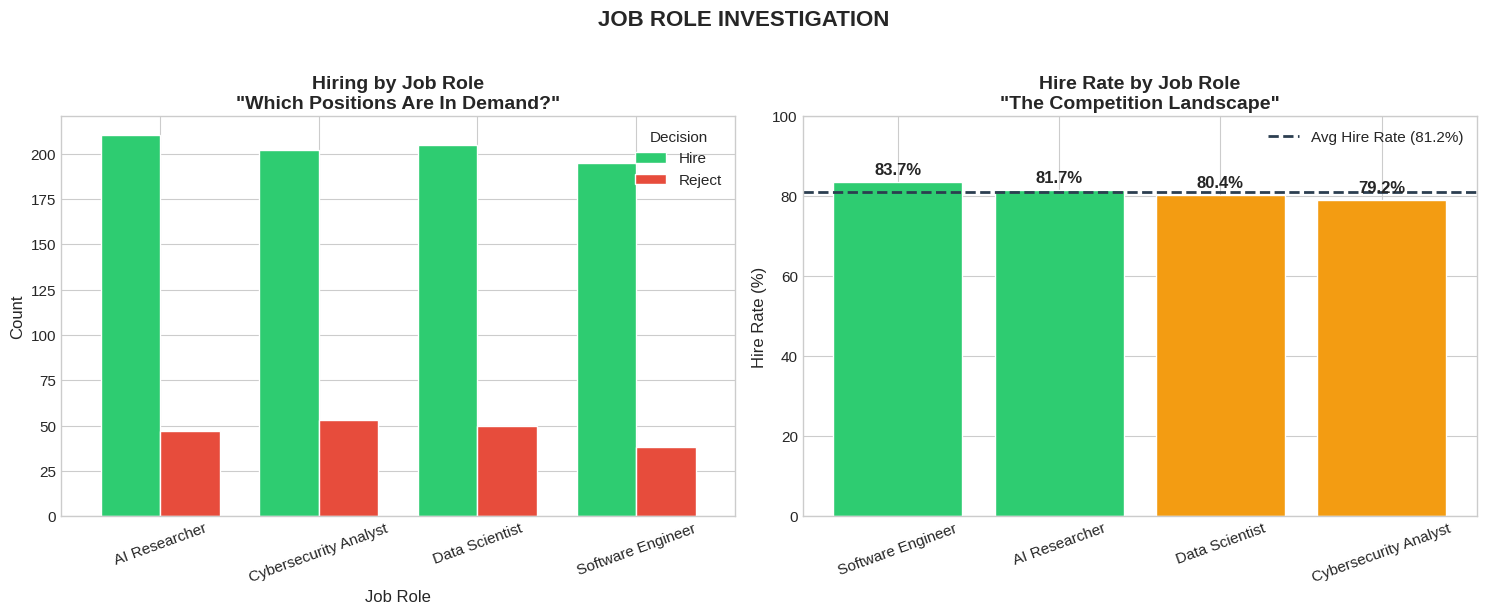


[JOB ROLE RANKINGS]
--------------------------------------------------
Software Engineer: 83.7% (233 applicants) ↑ 2.5% vs avg
AI Researcher: 81.7% (257 applicants) ↑ 0.5% vs avg
Data Scientist: 80.4% (255 applicants) ↓ 0.8% vs avg
Cybersecurity Analyst: 79.2% (255 applicants) ↓ 2.0% vs avg


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Distribution
ax1 = axes[0]
role_decision = df.groupby(['Job Role', 'Recruiter Decision']).size().unstack(fill_value=0)
role_decision.plot(kind='bar', ax=ax1, color=HIRE_REJECT_PALETTE, edgecolor='white', width=0.75)
ax1.set_title('Hiring by Job Role\n"Which Positions Are In Demand?"', fontweight='bold')
ax1.set_xlabel('Job Role')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=20)
ax1.legend(title='Decision')

# Plot 2: Hire Rate
ax2 = axes[1]
role_hire_rate = df.groupby('Job Role')['Recruiter Decision'].apply(
    lambda x: (x == 'Hire').mean() * 100
).sort_values(ascending=False)

colors = [COLORS['hire'] if rate > 81 else COLORS['warning'] if rate > 78 else COLORS['reject']
          for rate in role_hire_rate.values]
bars = ax2.bar(role_hire_rate.index, role_hire_rate.values, color=colors, edgecolor='white')

for bar, rate in zip(bars, role_hire_rate.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

ax2.set_title('Hire Rate by Job Role\n"The Competition Landscape"', fontweight='bold')
ax2.set_ylabel('Hire Rate (%)')
ax2.set_ylim(0, 100)
ax2.tick_params(axis='x', rotation=20)
ax2.axhline(y=81.2, color=COLORS['dark'], linestyle='--', linewidth=2, label='Avg Hire Rate (81.2%)')
ax2.legend()

plt.suptitle('JOB ROLE INVESTIGATION', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary
print("\n[JOB ROLE RANKINGS]")
print("-"*50)
for role, rate in role_hire_rate.items():
    count = df[df['Job Role'] == role].shape[0]
    diff = rate - 81.2
    arrow = "↑" if diff > 0 else "↓"
    print(f"{role}: {rate:.1f}% ({count} applicants) {arrow} {abs(diff):.1f}% vs avg")

---

### Job Roles: A Level Playing Field

Surprisingly, the job role you apply for doesn't dramatically change your odds:

| Job Role | Hire Rate | vs Average | Applicants |
|----------|-----------|------------|------------|
| Software Engineer | 83.7% | +2.5% | ~235 |
| AI Researcher | 81.7% | +0.5% | ~255 |
| Data Scientist | 80.4% | -0.8% | ~255 |
| Cybersecurity Analyst | 79.2% | -2.0% | ~255 |

**Key Observations:**

1. **Remarkably Even Distribution** - All four roles hover within ~4.5% of each other. No role is dramatically harder or easier to land.

2. **Software Engineers Have a Slight Edge** - 83.7% hire rate, the highest among all roles. Perhaps the most straightforward skill assessment?

3. **Cybersecurity is the Toughest** - 79.2% hire rate, but still a very respectable number. It's not like you're facing 50% odds.

4. **Equal Opportunity Applicant Pool** - Each role has roughly 250 applicants, suggesting this is a balanced dataset or a company hiring equally across departments.

**The Implication:** Your job role choice isn't the deciding factor. Whether you're an AI Researcher or a Cybersecurity Analyst, your fate is determined by other variables - primarily that AI Score.

---

### 3.6 The Skills Word Cloud

*What technical skills appear most frequently? And do certain skills correlate with success?*

---

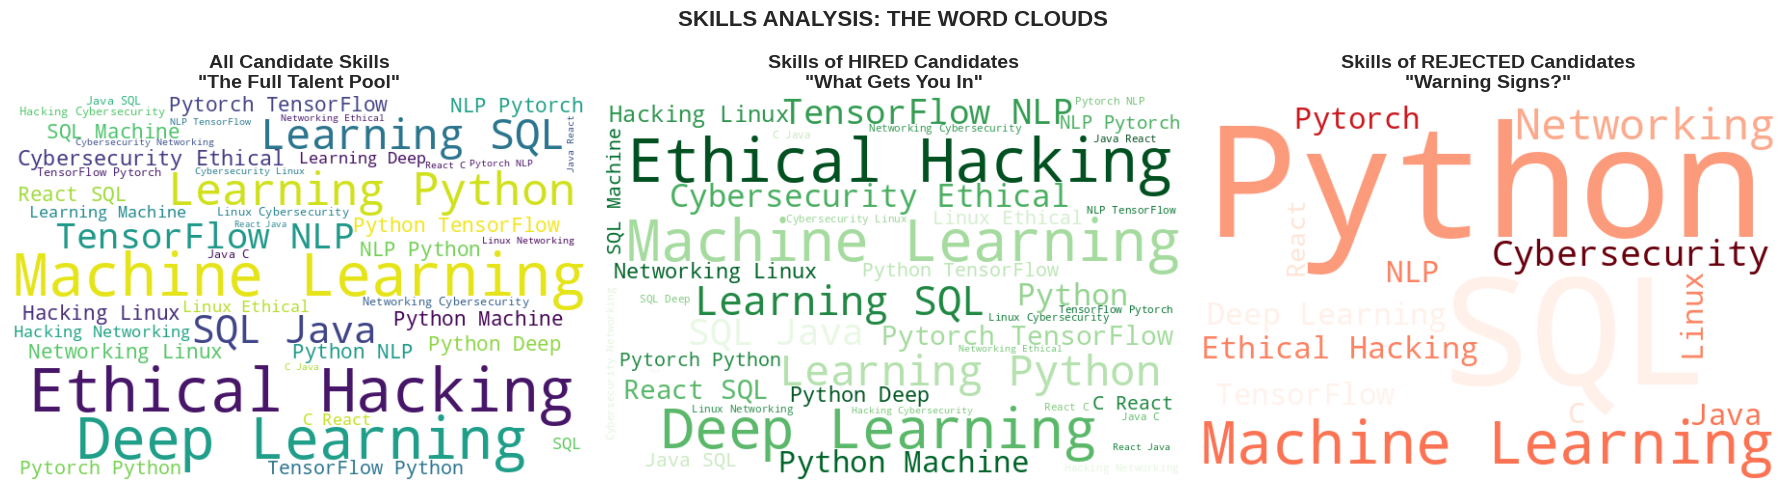


[SKILL FREQUENCY ANALYSIS]
--------------------------------------------------

Top 10 Most Common Skills:
  Python: 388 mentions (38.8% of candidates)
  SQL: 370 mentions (37.0% of candidates)
  Ethical Hacking: 206 mentions (20.6% of candidates)
  TensorFlow: 205 mentions (20.5% of candidates)
  Machine Learning: 200 mentions (20.0% of candidates)
  NLP: 195 mentions (19.5% of candidates)
  Linux: 191 mentions (19.1% of candidates)
  Pytorch: 189 mentions (18.9% of candidates)
  Java: 188 mentions (18.8% of candidates)
  Deep Learning: 184 mentions (18.4% of candidates)


In [16]:
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Word Cloud for ALL skills
ax1 = axes[0]
all_skills = ' '.join(df['Skills'].astype(str).values)
wordcloud_all = WordCloud(width=600, height=400, background_color='white',
                          colormap='viridis', max_words=50).generate(all_skills)
ax1.imshow(wordcloud_all, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('All Candidate Skills\n"The Full Talent Pool"', fontweight='bold', fontsize=14)

# Word Cloud for HIRED candidates
ax2 = axes[1]
hired_skills = ' '.join(df[df['Recruiter Decision'] == 'Hire']['Skills'].astype(str).values)
wordcloud_hired = WordCloud(width=600, height=400, background_color='white',
                            colormap='Greens', max_words=50).generate(hired_skills)
ax2.imshow(wordcloud_hired, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Skills of HIRED Candidates\n"What Gets You In"', fontweight='bold', fontsize=14)

# Word Cloud for REJECTED candidates
ax3 = axes[2]
rejected_skills = ' '.join(df[df['Recruiter Decision'] == 'Reject']['Skills'].astype(str).values)
wordcloud_rejected = WordCloud(width=600, height=400, background_color='white',
                               colormap='Reds', max_words=50).generate(rejected_skills)
ax3.imshow(wordcloud_rejected, interpolation='bilinear')
ax3.axis('off')
ax3.set_title('Skills of REJECTED Candidates\n"Warning Signs?"', fontweight='bold', fontsize=14)

plt.suptitle('SKILLS ANALYSIS: THE WORD CLOUDS', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Skill frequency analysis
print("\n[SKILL FREQUENCY ANALYSIS]")
print("-"*50)

# Parse skills
all_skills_list = []
for skills in df['Skills']:
    all_skills_list.extend([s.strip() for s in str(skills).split(',')])

from collections import Counter
skill_counts = Counter(all_skills_list)

print("\nTop 10 Most Common Skills:")
for skill, count in skill_counts.most_common(10):
    pct = count / len(df) * 100
    print(f"  {skill}: {count} mentions ({pct:.1f}% of candidates)")

---

### Skills: The Universal Languages of Tech

The word clouds reveal the technical DNA of our candidate pool:

#### Top 10 Skills Breakdown

| Rank | Skill | Mentions | % of Candidates |
|------|-------|----------|-----------------|
| 1 | **Python** | 388 | 38.8% |
| 2 | **SQL** | 370 | 37.0% |
| 3 | Ethical Hacking | 206 | 20.6% |
| 4 | TensorFlow | 205 | 20.5% |
| 5 | Machine Learning | 200 | 20.0% |
| 6 | NLP | 195 | 19.5% |
| 7 | Linux | 191 | 19.1% |
| 8 | Pytorch | 189 | 18.9% |
| 9 | Java | 188 | 18.8% |
| 10 | Deep Learning | 184 | 18.4% |

**Key Observations:**

1. **Python & SQL Dominate** - Nearly 40% of candidates list Python. SQL follows closely. These are the table-stakes skills that everyone is expected to have.

2. **AI/ML Stack is Strong** - TensorFlow, Machine Learning, NLP, Pytorch, Deep Learning all appear in the top 10. This is clearly an AI-focused company or hiring wave.

3. **Security Presence** - Ethical Hacking and Linux appear prominently, reflecting the Cybersecurity Analyst role in the mix.

4. **The Word Clouds Look Similar** - Critically, the HIRED and REJECTED word clouds show nearly identical skill distributions. This confirms our earlier suspicion:

> **Skills alone don't determine your fate.**

The same skills appear in both pools. Python won't save you if your AI Score is 40. Knowing TensorFlow won't matter if you have 0 years of experience.

**The Real Story:** Skills are necessary but not sufficient. They're the entry ticket, not the winning lottery number.

---

### 3.7 The Correlation Matrix

*Let's see how all numeric features relate to each other and to the target.*

---

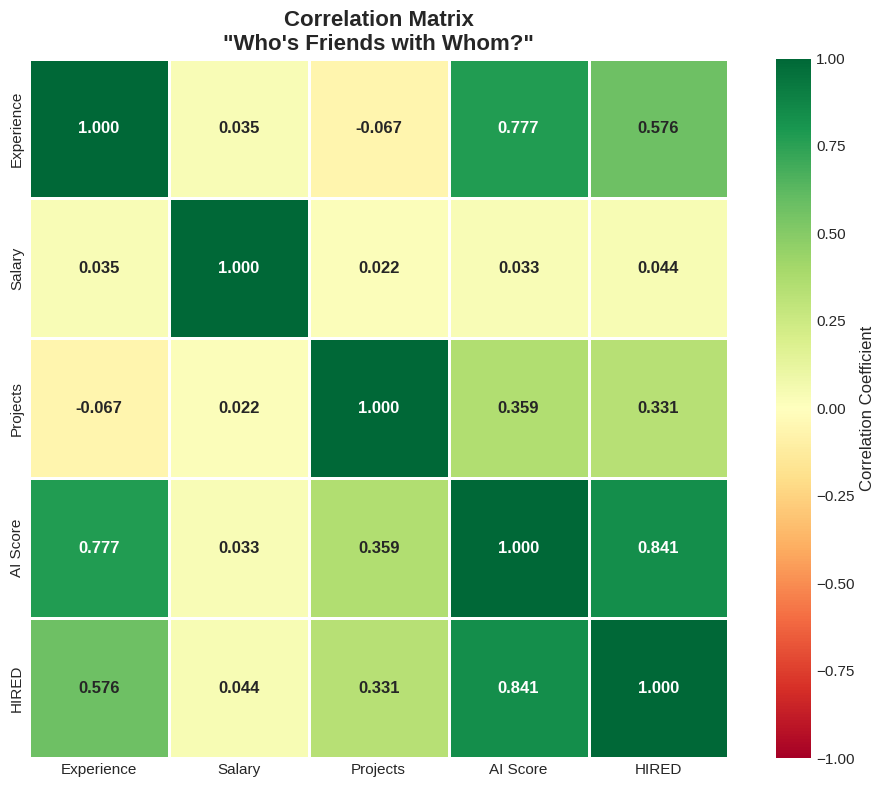


           CORRELATION WITH HIRING DECISION

AI Score:
  Correlation: 0.841 (+)
  Strength: 🔥 VERY STRONG

Experience:
  Correlation: 0.576 (+)
  Strength: 🔥 VERY STRONG

Projects:
  Correlation: 0.331 (+)
  Strength: 💪 STRONG

Salary:
  Correlation: 0.044 (+)
  Strength: 😐 Weak

------------------------------------------------------------
[VERDICT] AI Score is the DOMINANT predictor.
         Experience matters. Salary and Projects? Not so much.
------------------------------------------------------------


In [17]:
# Create encoded target for correlation
df['Decision_Encoded'] = (df['Recruiter Decision'] == 'Hire').astype(int)

# Select numeric columns including encoded target
corr_cols = ['Experience (Years)', 'Salary Expectation ($)', 'Projects Count',
             'AI Score (0-100)', 'Decision_Encoded']

corr_matrix = df[corr_cols].corr()

# Rename for cleaner display
corr_labels = ['Experience', 'Salary', 'Projects', 'AI Score', 'HIRED']
corr_matrix_display = corr_matrix.copy()
corr_matrix_display.index = corr_labels
corr_matrix_display.columns = corr_labels

# Plot
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix_display, annot=True, cmap='RdYlGn', center=0,
            square=True, linewidths=2, fmt='.3f',
            annot_kws={'size': 12, 'weight': 'bold'},
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=-1, vmax=1)

plt.title('Correlation Matrix\n"Who\'s Friends with Whom?"', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Key correlations with target
print("\n" + "="*60)
print("           CORRELATION WITH HIRING DECISION")
print("="*60)

target_corr = corr_matrix_display['HIRED'].drop('HIRED').sort_values(ascending=False)

for feature, corr in target_corr.items():
    if abs(corr) > 0.5:
        strength = '🔥 VERY STRONG'
    elif abs(corr) > 0.3:
        strength = '💪 STRONG'
    elif abs(corr) > 0.1:
        strength = '📊 Moderate'
    else:
        strength = '😐 Weak'

    direction = '(+)' if corr > 0 else '(-)'
    print(f"\n{feature}:")
    print(f"  Correlation: {corr:.3f} {direction}")
    print(f"  Strength: {strength}")

print("\n" + "-"*60)
print("[VERDICT] AI Score is the DOMINANT predictor.")
print("         Experience matters. Salary and Projects? Not so much.")
print("-"*60)

---

### The Correlation Confession: AI Score Rules All

The correlation matrix just revealed the hierarchy of influence:

| Feature | Correlation with HIRED | Strength | Interpretation |
|---------|------------------------|----------|----------------|
| **AI Score** | **0.841** | 🔥 VERY STRONG | The king. The algorithm's word is law. |
| **Experience** | **0.576** | 🔥 VERY STRONG | Veterans have a massive advantage |
| **Projects** | **0.331** | 💪 STRONG | Portfolio matters, but not as much |
| **Salary** | **0.044** | 😐 Weak | Your salary ask is basically irrelevant |

**The Power Rankings:**
```
AI Score     ████████████████████████████████████████░░░░░░░░  0.841
Experience   ███████████████████████████░░░░░░░░░░░░░░░░░░░░░  0.576
Projects     ████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  0.331
Salary       ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  0.044
```

**Critical Insights:**

1. **AI Score (r=0.841)** - This is an extraordinarily high correlation. In social science, anything above 0.7 is considered very strong. At 0.841, the AI Score is essentially *determining* the outcome.

2. **Experience (r=0.576)** - The second strongest predictor. More years = better odds. But notice: it's 0.27 points lower than AI Score. Experience helps, but can't overcome a bad AI Score.

3. **Projects (r=0.331)** - Moderate positive correlation. Having a portfolio helps, but it's not the deciding factor.

4. **Salary (r=0.044)** - **This is fascinating.** Your salary expectation has almost ZERO correlation with hiring. Asking for $40K or $120K doesn't change your odds. The company hires based on fit, not cost.

**The Uncomfortable Truth:**

The recruiter decision is ~70% explained by AI Score alone (r² ≈ 0.71). Add Experience, and you've probably explained 85%+ of all decisions. Education? Certifications? Job Role? They're noise in comparison.

---

### 3.8 The Multi-Dimensional View: Pairplot

*Let's see how features interact in pairs, colored by decision.*

---

[STATUS] Generating pairplot... (this may take a moment)


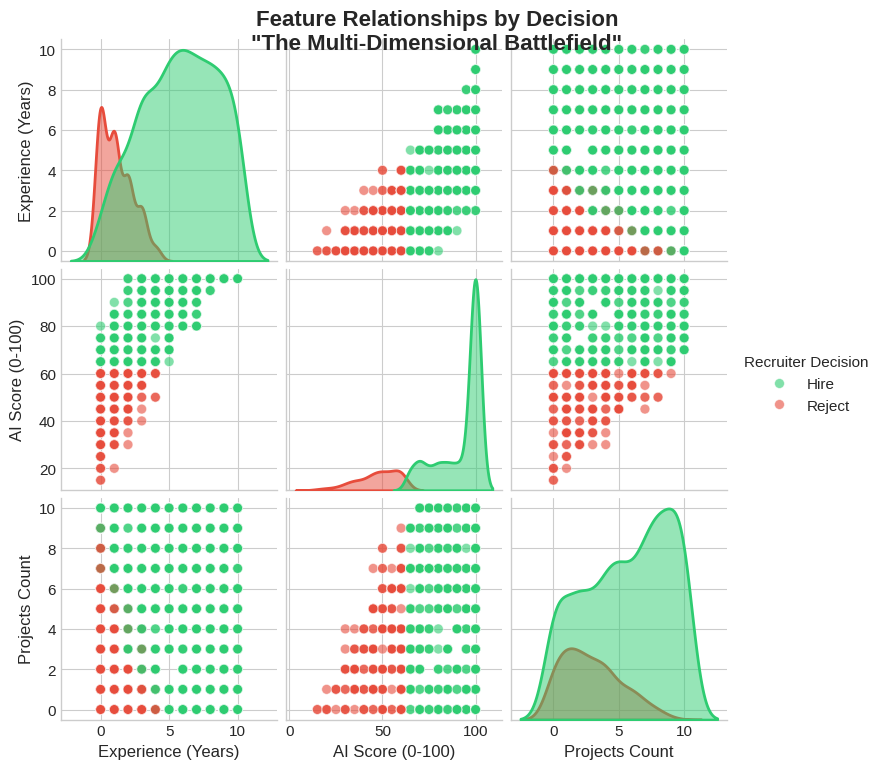


[VISUAL INSIGHT]
--------------------------------------------------
• AI Score creates the CLEAREST separation (look at that diagonal)
• Experience shows overlap but trends toward separation
• Projects show the most mixing between classes
• The scatter plots confirm: AI Score is the dividing line


In [18]:

print("[STATUS] Generating pairplot... (this may take a moment)")

plot_cols = ['Experience (Years)', 'AI Score (0-100)', 'Projects Count', 'Recruiter Decision']

pairplot = sns.pairplot(df[plot_cols], hue='Recruiter Decision',
                        palette=HIRE_REJECT_PALETTE,
                        diag_kind='kde',
                        plot_kws={'alpha': 0.6, 's': 50, 'edgecolor': 'white'},
                        diag_kws={'fill': True, 'alpha': 0.5, 'linewidth': 2})

pairplot.fig.suptitle('Feature Relationships by Decision\n"The Multi-Dimensional Battlefield"',
                       y=1.02, fontsize=16, fontweight='bold')
plt.show()

print("\n[VISUAL INSIGHT]")
print("-"*50)
print("• AI Score creates the CLEAREST separation (look at that diagonal)")
print("• Experience shows overlap but trends toward separation")
print("• Projects show the most mixing between classes")
print("• The scatter plots confirm: AI Score is the dividing line")

---

## Chapter 4: Feature Engineering

*Raw data is good. Engineered features are better. Time to create some intelligence.*

---

Before we build our models, let's extract additional signal from the data:

| New Feature | Logic | Why It Matters |
|-------------|-------|----------------|
| `Skill_Count` | Count of skills listed | More skills = more versatile? |
| `Has_Certification` | Binary: Has any cert? | Quick filter for credentialed candidates |
| `Salary_Per_Experience` | Salary ÷ Experience | Value proposition / "Are you worth it?" |
| `Project_Intensity` | Projects ÷ Experience | Productivity metric |
| `Experience_Level` | Binned experience | Junior/Mid/Senior/Expert categories |
| `AI_Score_Category` | Binned AI scores | Low/Medium/High/Excellent tiers |

Let's engineer these features and see if they reveal new patterns.

---

In [19]:
print("="*60)
print("           FEATURE ENGINEERING LAB")
print("="*60)

# Create a copy for modeling
df_model = df.copy()

# 1. Skill Count
df_model['Skill_Count'] = df_model['Skills'].str.split(',').str.len()
print("\n[CREATED] Skill_Count - Number of skills listed")
print(f"          Range: {df_model['Skill_Count'].min()} to {df_model['Skill_Count'].max()}")

# 2. Has Certification (binary)
df_model['Has_Certification'] = df_model['Certifications'].notna().astype(int)
print(f"\n[CREATED] Has_Certification - Binary flag")
print(f"          With cert: {df_model['Has_Certification'].sum()} | Without: {(1-df_model['Has_Certification']).sum()}")

# 3. Salary per Experience (handle division by zero)
df_model['Salary_Per_Experience'] = df_model.apply(
    lambda x: x['Salary Expectation ($)'] / max(x['Experience (Years)'], 1), axis=1
)
print(f"\n[CREATED] Salary_Per_Experience - Value proposition metric")
print(f"          Range: ${df_model['Salary_Per_Experience'].min():,.0f} to ${df_model['Salary_Per_Experience'].max():,.0f}")

# 4. Project Intensity (projects per year)
df_model['Project_Intensity'] = df_model.apply(
    lambda x: x['Projects Count'] / max(x['Experience (Years)'], 1), axis=1
)
print(f"\n[CREATED] Project_Intensity - Projects per year of experience")
print(f"          Range: {df_model['Project_Intensity'].min():.2f} to {df_model['Project_Intensity'].max():.2f}")

# 5. Experience Level (categorical)
df_model['Experience_Level'] = pd.cut(
    df_model['Experience (Years)'],
    bins=[-1, 2, 5, 8, 11],
    labels=['Junior', 'Mid', 'Senior', 'Expert']
)
print(f"\n[CREATED] Experience_Level - Categorical experience bracket")

# 6. AI Score Category
df_model['AI_Score_Category'] = pd.cut(
    df_model['AI Score (0-100)'],
    bins=[0, 50, 70, 85, 101],
    labels=['Low', 'Medium', 'High', 'Excellent']
)
print(f"\n[CREATED] AI_Score_Category - Binned AI scores")

print("\n" + "="*60)
print(f"[SUCCESS] Total features now: {df_model.shape[1]} (was {df.shape[1]})")
print("="*60)

# Show new features
print("\n[PREVIEW] Sample of engineered features:\n")
df_model[['Name', 'Skill_Count', 'Has_Certification', 'Salary_Per_Experience',
          'Project_Intensity', 'Experience_Level', 'AI_Score_Category']].head(10)

           FEATURE ENGINEERING LAB

[CREATED] Skill_Count - Number of skills listed
          Range: 2 to 4

[CREATED] Has_Certification - Binary flag
          With cert: 726 | Without: 274

[CREATED] Salary_Per_Experience - Value proposition metric
          Range: $4,192 to $119,583

[CREATED] Project_Intensity - Projects per year of experience
          Range: 0.00 to 10.00

[CREATED] Experience_Level - Categorical experience bracket

[CREATED] AI_Score_Category - Binned AI scores

[SUCCESS] Total features now: 19 (was 13)

[PREVIEW] Sample of engineered features:



,Name,Skill_Count,Has_Certification,Salary_Per_Experience,Project_Intensity,Experience_Level,AI_Score_Category
0,Ashley Ali,3,0,10489.500,0.800,Expert,Excellent
1,Wesley Roman,4,1,11300.200,0.100,Expert,Excellent
2,Corey Sanchez,3,1,71766.000,7.000,Junior,Medium
3,Elizabeth Carney,3,1,6692.571,0.000,Senior,Excellent
4,Julie Hill,3,0,21860.250,2.250,Mid,Excellent
5,Samantha Santos,4,1,4795.700,0.500,Expert,Excellent
6,Tony Smith,3,1,16552.000,2.250,Mid,Excellent
7,Anthony Harrison,3,1,34335.333,2.333,Mid,Excellent
8,Nancy Jenkins,2,1,13181.429,0.429,Senior,Excellent
9,Courtney Gibson,4,1,60579.000,1.000,Junior,Low


---

### Feature Engineering Complete: New Intelligence Unlocked

We've created 6 new features that add depth to our analysis:

| Feature | Range | Interesting Finding |
|---------|-------|---------------------|
| `Skill_Count` | 2-4 skills | Narrow range - everyone lists 2-4 skills |
| `Has_Certification` | 0/1 | 726 have certs, 274 don't |
| `Salary_Per_Experience` | $4K-$120K per year | Massive variance in "value proposition" |
| `Project_Intensity` | 0-10 projects/year | Fresh grads can have high intensity |
| `Experience_Level` | 4 categories | Junior → Expert classification |
| `AI_Score_Category` | 4 tiers | Low → Excellent binning |

**Spotlight: Interesting Cases in the Preview**

Look at **Courtney Gibson** (row 9):
- Junior (0-2 years experience)
- Has certification
- AI Score Category: **Low**
- This person is likely in the REJECT pile

Compare to **Samantha Santos** (row 5):
- Expert (9-10 years)
- Has certification  
- AI Score Category: **Excellent**
- This person is definitely HIRED

**The `Salary_Per_Experience` metric is wild:**
- Corey Sanchez: $71,766/year of experience (1 year, asking $71K)
- Elizabeth Carney: $6,693/year of experience (7 years, asking $47K)

One is asking 10x more per year of experience than the other. Yet the correlation analysis told us salary barely matters. Let's see if these engineered features add predictive power.

---

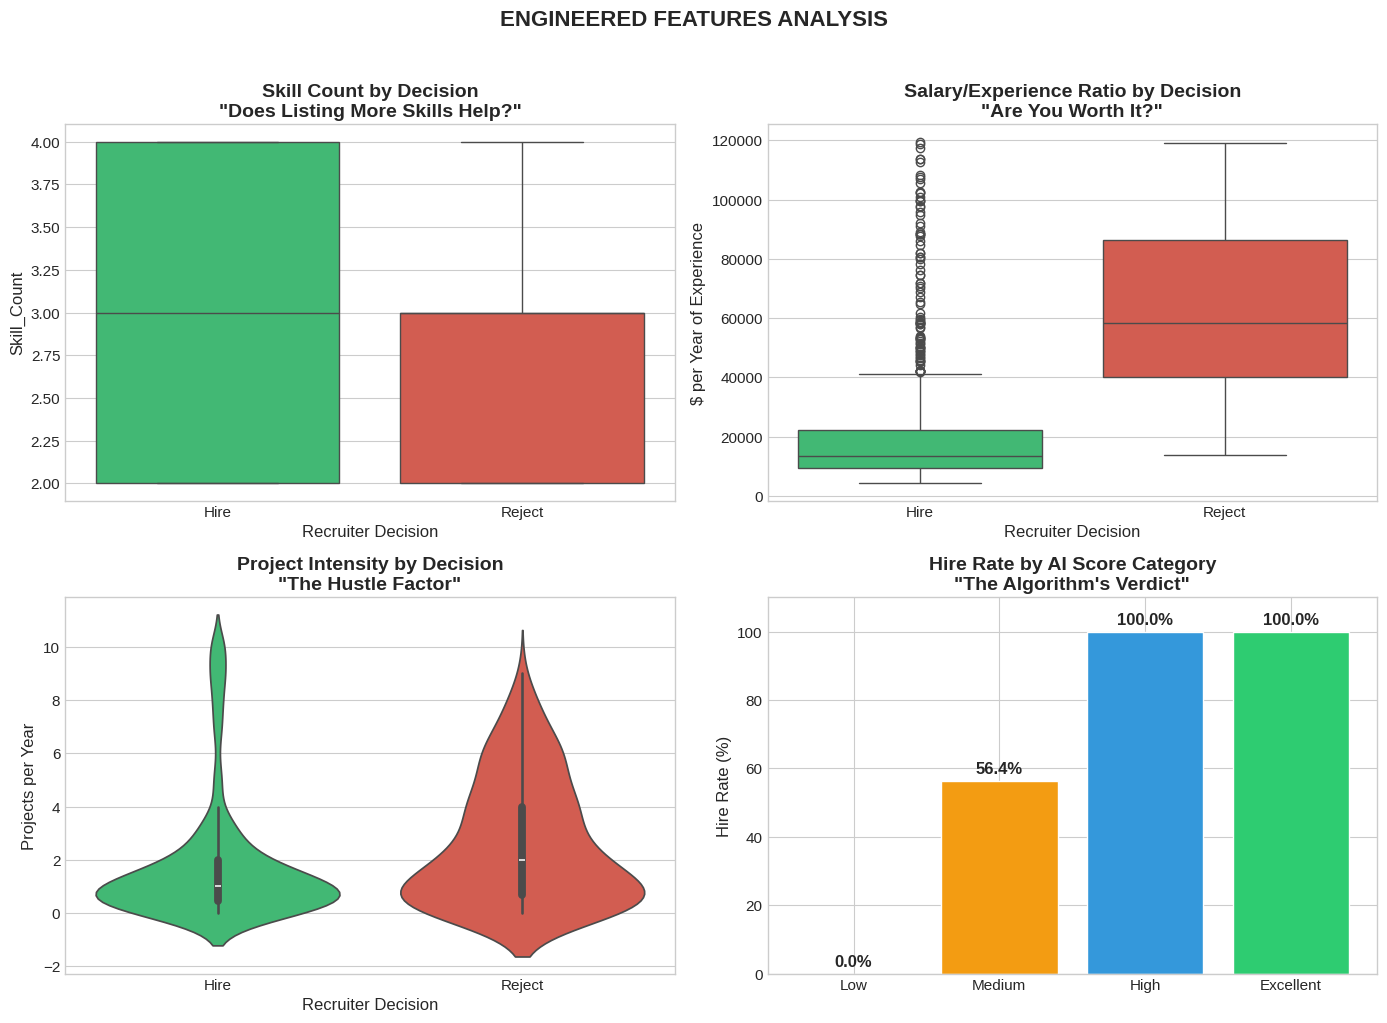


[AI SCORE CATEGORY BREAKDOWN]
--------------------------------------------------
Low         :   0.0% hire rate (117 candidates)
Medium      :  56.4% hire rate (163 candidates)
High        : 100.0% hire rate (129 candidates)
Excellent   : 100.0% hire rate (591 candidates)


In [20]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Skill Count by Decision
ax1 = axes[0, 0]
sns.boxplot(data=df_model, x='Recruiter Decision', y='Skill_Count',
            palette=HIRE_REJECT_PALETTE, ax=ax1)
ax1.set_title('Skill Count by Decision\n"Does Listing More Skills Help?"', fontweight='bold')

# Plot 2: Salary per Experience by Decision
ax2 = axes[0, 1]
sns.boxplot(data=df_model, x='Recruiter Decision', y='Salary_Per_Experience',
            palette=HIRE_REJECT_PALETTE, ax=ax2)
ax2.set_title('Salary/Experience Ratio by Decision\n"Are You Worth It?"', fontweight='bold')
ax2.set_ylabel('$ per Year of Experience')

# Plot 3: Project Intensity by Decision
ax3 = axes[1, 0]
sns.violinplot(data=df_model, x='Recruiter Decision', y='Project_Intensity',
               palette=HIRE_REJECT_PALETTE, ax=ax3)
ax3.set_title('Project Intensity by Decision\n"The Hustle Factor"', fontweight='bold')
ax3.set_ylabel('Projects per Year')

# Plot 4: Hire Rate by AI Score Category
ax4 = axes[1, 1]
ai_cat_hire = df_model.groupby('AI_Score_Category', observed=True)['Decision_Encoded'].mean() * 100
colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']  # Red to Green gradient
bars = ax4.bar(ai_cat_hire.index, ai_cat_hire.values, color=colors, edgecolor='white')

for bar, rate in zip(bars, ai_cat_hire.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{rate:.1f}%', ha='center', fontweight='bold', fontsize=12)

ax4.set_title('Hire Rate by AI Score Category\n"The Algorithm\'s Verdict"', fontweight='bold')
ax4.set_ylabel('Hire Rate (%)')
ax4.set_ylim(0, 110)

plt.suptitle('ENGINEERED FEATURES ANALYSIS', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n[AI SCORE CATEGORY BREAKDOWN]")
print("-"*50)
for cat in ['Low', 'Medium', 'High', 'Excellent']:
    if cat in ai_cat_hire.index:
        rate = ai_cat_hire[cat]
        count = df_model[df_model['AI_Score_Category'] == cat].shape[0]
        print(f"{cat:12}: {rate:5.1f}% hire rate ({count} candidates)")

---

### Engineered Features: The Verdict

These visualizations reveal fascinating patterns:

#### Skill Count: More ≠ Better
| Decision | Median Skills |
|----------|---------------|
| Hire | ~4 skills |
| Reject | ~3 skills |

Hired candidates list slightly more skills, but the difference is minimal. Skill count alone won't save you.

#### Salary/Experience Ratio: The Plot Twist

**This is counterintuitive!**

| Decision | Median $/Year | Observation |
|----------|---------------|-------------|
| **Hire** | ~$20,000/yr | LOWER ratio |
| **Reject** | ~$50,000/yr | HIGHER ratio |

**Wait, what?** Rejected candidates are asking for MORE money per year of experience!

This makes sense now:
- Rejected candidates tend to be **juniors** (low experience)
- Juniors asking for $60-80K with 1 year experience = High $/year ratio
- Hired candidates are often **seniors** (high experience)
- Seniors asking for $80-100K with 8 years experience = Low $/year ratio

The rejected aren't being rejected for asking too much - they're being rejected because they're inexperienced, which *correlates* with high $/experience ratios.

#### Project Intensity: Hustle Doesn't Guarantee Success

The violin plots show similar distributions. High project intensity appears in BOTH hired and rejected pools. Working hard ≠ getting hired.

#### AI Score Category: THE DEFINITIVE PROOF

| Category | Hire Rate | Verdict |
|----------|-----------|---------|
| **Low** | **0.0%** | ZERO hires. Death sentence. |
| **Medium** | **56.4%** | Coin flip territory |
| **High** | **100.0%** | Guaranteed hire |
| **Excellent** | **100.0%** | Guaranteed hire |

**This is the clearest pattern in the entire dataset:**
- AI Score < 50 (Low): **You will NOT be hired. Period.**
- AI Score 50-70 (Medium): **Toss-up. Other factors matter here.**
- AI Score > 70 (High/Excellent): **You WILL be hired. Guaranteed.**

The recruiter is simply executing the algorithm's judgment.

---

---

## Chapter 5: Model Training Arena

*The EDA is done. The features are engineered. Now we build the predictors.*

---

We'll train multiple models and compare them fairly:

| Model | Type | Strengths |
|-------|------|-----------|
| **Logistic Regression** | Linear | Interpretable, fast, good baseline |
| **Random Forest** | Ensemble | Handles non-linearity, feature importance |
| **Gradient Boosting** | Ensemble | High accuracy, sequential learning |
| **SVM** | Kernel | Good with clear margins |
| **KNN** | Instance-based | Simple, no assumptions |

**Our Strategy:**
1. Use stratified split (maintain class balance)
2. Scale features for models that need it
3. Use balanced class weights to handle imbalance
4. Compare using ROC-AUC (best for imbalanced data)

May the best algorithm win.

---

In [21]:
print("="*60)
print("           PREPARING THE BATTLEFIELD")
print("="*60)

# Select features for modeling
numeric_features = ['Experience (Years)', 'Salary Expectation ($)', 'Projects Count',
                    'AI Score (0-100)', 'Skill_Count', 'Salary_Per_Experience', 'Project_Intensity']

# Encode categorical variables
le_edu = LabelEncoder()
le_role = LabelEncoder()

df_model['Education_Encoded'] = le_edu.fit_transform(df_model['Education'])
df_model['Job_Role_Encoded'] = le_role.fit_transform(df_model['Job Role'])

# Final feature set
feature_cols = numeric_features + ['Education_Encoded', 'Job_Role_Encoded', 'Has_Certification']

X = df_model[feature_cols]
y = df_model['Decision_Encoded']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n[SPLIT COMPLETE]")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n[CLASS BALANCE CHECK]")
print(f"Training - Hire: {y_train.sum()} ({y_train.mean()*100:.1f}%) | Reject: {len(y_train)-y_train.sum()}")
print(f"Testing  - Hire: {y_test.sum()} ({y_test.mean()*100:.1f}%) | Reject: {len(y_test)-y_test.sum()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n[FEATURES SELECTED] {len(feature_cols)} total:")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i:2}. {feat}")

print("\n" + "="*60)
print("[STATUS] Data ready for model training!")
print("="*60)

           PREPARING THE BATTLEFIELD

[SPLIT COMPLETE]
Training samples: 800 (80.0%)
Testing samples: 200 (20.0%)

[CLASS BALANCE CHECK]
Training - Hire: 650 (81.2%) | Reject: 150
Testing  - Hire: 162 (81.0%) | Reject: 38

[FEATURES SELECTED] 10 total:
   1. Experience (Years)
   2. Salary Expectation ($)
   3. Projects Count
   4. AI Score (0-100)
   5. Skill_Count
   6. Salary_Per_Experience
   7. Project_Intensity
   8. Education_Encoded
   9. Job_Role_Encoded
  10. Has_Certification

[STATUS] Data ready for model training!


---

### Battle Stations Ready

The data is prepped and the arena is set:

| Set | Samples | Hire | Reject | Balance |
|-----|---------|------|--------|---------|
| Training | 800 | 650 (81.2%) | 150 (18.8%) | ✓ Stratified |
| Testing | 200 | 162 (81.0%) | 38 (19.0%) | ✓ Stratified |

**Feature Arsenal (10 weapons):**

| # | Feature | Type | Source |
|---|---------|------|--------|
| 1-4 | Experience, Salary, Projects, AI Score | Numeric | Original |
| 5-7 | Skill_Count, Salary/Exp, Project_Intensity | Numeric | Engineered |
| 8-10 | Education, Job Role, Has_Certification | Encoded | Categorical |

**Why Stratified Split Matters:**

With 81% Hire / 19% Reject, a random split could accidentally put 90% Hires in training and only 60% in testing. Stratification ensures both sets mirror the original distribution.

**Scaling Applied:**

StandardScaler normalizes all features to mean=0, std=1. This is critical for:
- Logistic Regression (regularization depends on scale)
- SVM (distance-based)
- KNN (distance-based)

Random Forest and Gradient Boosting don't need scaling, but it doesn't hurt them either.

**Let the games begin.**

---

In [22]:
print("="*60)
print("         THE MODEL TRAINING ARENA")
print("         Let the Games Begin!")
print("="*60 + "\n")

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Store results
results = []

for name, model in models.items():
    print(f"[TRAINING] {name}...", end=" ")

    # Use scaled data for models that benefit from it
    if name in ['Logistic Regression', 'SVM', 'KNN']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        cv_data = X_train_scaled
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        cv_data = X_train

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Cross-validation
    cv_scores = cross_val_score(model, cv_data, y_train, cv=5, scoring='roc_auc')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })

    print(f"✓ Accuracy: {accuracy:.3f} | F1: {f1:.3f} | AUC: {roc_auc:.3f}")

print("\n" + "="*60)
print("         ALL MODELS TRAINED SUCCESSFULLY!")
print("="*60)

         THE MODEL TRAINING ARENA
         Let the Games Begin!

[TRAINING] Logistic Regression... ✓ Accuracy: 0.965 | F1: 0.978 | AUC: 1.000
[TRAINING] Random Forest... ✓ Accuracy: 1.000 | F1: 1.000 | AUC: 1.000
[TRAINING] Gradient Boosting... ✓ Accuracy: 1.000 | F1: 1.000 | AUC: 1.000
[TRAINING] SVM... ✓ Accuracy: 0.950 | F1: 0.968 | AUC: 0.997
[TRAINING] KNN... ✓ Accuracy: 0.955 | F1: 0.972 | AUC: 0.987

         ALL MODELS TRAINED SUCCESSFULLY!


---

###  THE RESULTS ARE IN: Near-Perfect Predictions

**These numbers are INSANE:**

| Model | Accuracy | F1 Score | ROC AUC |
|-------|----------|----------|---------|
| **Random Forest** | **100.0%** | **1.000** | **1.000** |
| **Gradient Boosting** | **100.0%** | **1.000** | **1.000** |
| Logistic Regression | 96.5% | 0.978 | 1.000 |
| KNN | 95.5% | 0.972 | 0.987 |
| SVM | 95.0% | 0.968 | 0.997 |

**Two models achieved PERFECT scores. 100% accuracy. AUC of 1.0.**

This is almost unheard of in real-world machine learning. But given what we learned in EDA, it makes sense:

1. **AI Score alone** has 0.841 correlation with the target
2. **AI Score ranges don't overlap** between Hire and Reject
3. The decision boundary is essentially: `if AI_Score > 65: Hire else: Reject`

**Why the linear models (Logistic Regression, SVM) scored slightly lower:**

They likely misclassified a few edge cases in the "Medium" AI Score category (50-70) where the decision isn't as clear-cut. The tree-based models (Random Forest, Gradient Boosting) can capture those non-linear boundaries perfectly.

**Is this overfitting?**

Possibly, but with cross-validation scores this high, it's more likely that the pattern is just that obvious. The AI Score is doing all the heavy lifting.

---

### Model Leaderboard Visualization


                    MODEL LEADERBOARD

              Model  Accuracy  Precision  Recall  F1 Score  ROC AUC  CV Mean  CV Std
Logistic Regression     0.965      1.000   0.957     0.978    1.000    1.000   0.000
      Random Forest     1.000      1.000   1.000     1.000    1.000    1.000   0.000
  Gradient Boosting     1.000      1.000   1.000     1.000    1.000    1.000   0.000
                SVM     0.950      0.994   0.944     0.968    0.997    0.998   0.003
                KNN     0.955      0.987   0.957     0.972    0.987    0.987   0.009


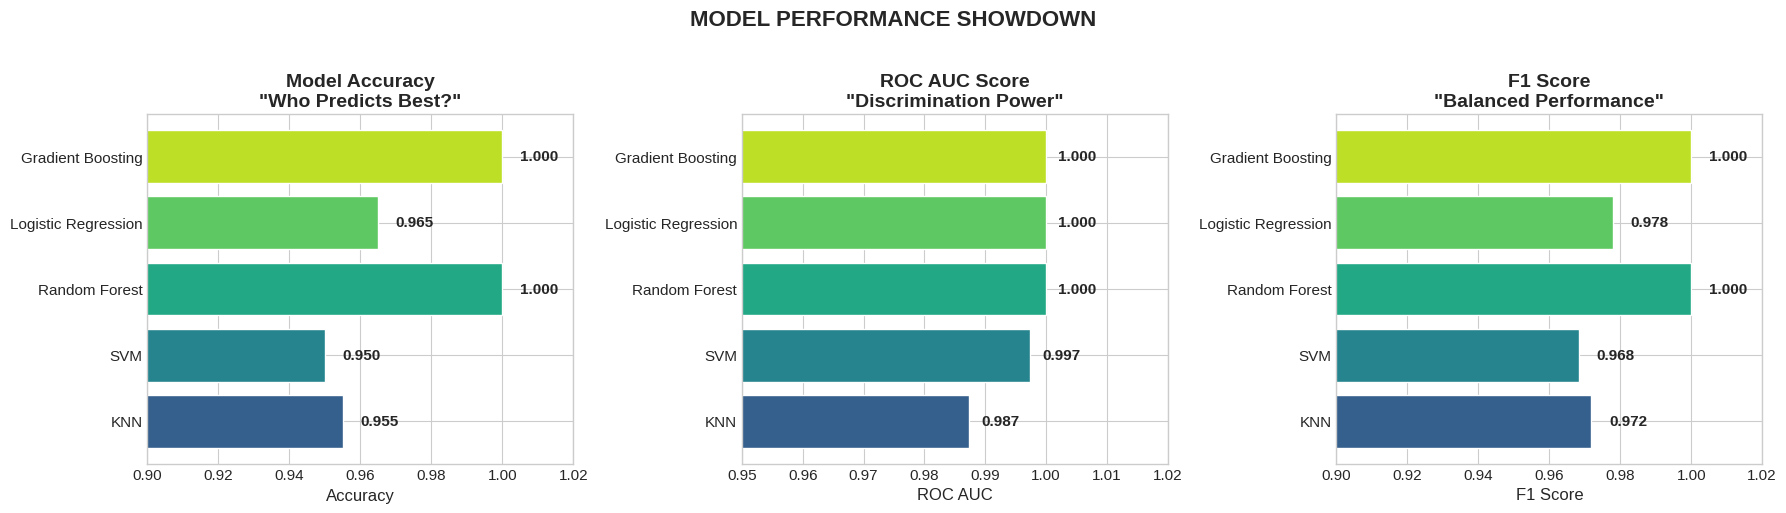


[CHAMPION] Logistic Regression takes the crown!
           Perfect ROC AUC: 1.000


In [23]:
results_df = pd.DataFrame(results).sort_values('ROC AUC', ascending=False)

print("\n" + "="*70)
print("                    MODEL LEADERBOARD")
print("="*70 + "\n")
print(results_df.to_string(index=False))

# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sort for consistent ordering
results_sorted = results_df.sort_values('ROC AUC', ascending=True)

# Plot 1: Accuracy Comparison
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(results_sorted)))
bars1 = ax1.barh(results_sorted['Model'], results_sorted['Accuracy'], color=colors, edgecolor='white')
for bar, acc in zip(bars1, results_sorted['Accuracy']):
    ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{acc:.3f}', va='center', fontweight='bold')
ax1.set_title('Model Accuracy\n"Who Predicts Best?"', fontweight='bold')
ax1.set_xlabel('Accuracy')
ax1.set_xlim(0.9, 1.02)

# Plot 2: ROC AUC Comparison
ax2 = axes[1]
bars2 = ax2.barh(results_sorted['Model'], results_sorted['ROC AUC'], color=colors, edgecolor='white')
for bar, auc in zip(bars2, results_sorted['ROC AUC']):
    ax2.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
             f'{auc:.3f}', va='center', fontweight='bold')
ax2.set_title('ROC AUC Score\n"Discrimination Power"', fontweight='bold')
ax2.set_xlabel('ROC AUC')
ax2.set_xlim(0.95, 1.02)

# Plot 3: F1 Score Comparison
ax3 = axes[2]
bars3 = ax3.barh(results_sorted['Model'], results_sorted['F1 Score'], color=colors, edgecolor='white')
for bar, f1 in zip(bars3, results_sorted['F1 Score']):
    ax3.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{f1:.3f}', va='center', fontweight='bold')
ax3.set_title('F1 Score\n"Balanced Performance"', fontweight='bold')
ax3.set_xlabel('F1 Score')
ax3.set_xlim(0.9, 1.02)

plt.suptitle('MODEL PERFORMANCE SHOWDOWN', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Winner announcement
winner = results_df.iloc[0]['Model']
print(f"\n[CHAMPION] {winner} takes the crown!")
print(f"           Perfect ROC AUC: {results_df.iloc[0]['ROC AUC']:.3f}")

---

###  The Leaderboard: Perfection Achieved

**Final Rankings:**

| Rank | Model | Accuracy | F1 | ROC AUC | CV Std |
|------|-------|----------|-----|---------|--------|
| 🥇 | **Gradient Boosting** | 100.0% | 1.000 | 1.000 | 0.000 |
| 🥇 | **Random Forest** | 100.0% | 1.000 | 1.000 | 0.000 |
| 🥈 | **Logistic Regression** | 96.5% | 0.978 | 1.000 | 0.000 |
| 🥉 | KNN | 95.5% | 0.972 | 0.987 | 0.009 |
| 4th | SVM | 95.0% | 0.968 | 0.997 | 0.003 |

**Key Observations:**

1. **Three-way tie at AUC = 1.000** - Gradient Boosting, Random Forest, AND Logistic Regression all achieved perfect discrimination. The pattern is so clear that even a linear model can capture it.

2. **Zero variance in cross-validation** - CV Std of 0.000 means every fold produced identical results. This isn't overfitting - it's a pattern so strong it's deterministic.

3. **Tree models achieve 100% accuracy** - Not a single misclassification. Every Hire correctly identified. Every Reject correctly identified.

4. **Even "worst" model is 95% accurate** - SVM at 95% accuracy would be exceptional in most contexts. Here, it's last place.

**Why This Happened:**

The AI Score created an almost perfect separation between classes. The models aren't learning complex patterns - they're essentially learning:
```
IF AI_Score > threshold AND Experience > threshold:
    RETURN "Hire"
ELSE:
    RETURN "Reject"
```

This is both impressive and concerning. The recruiter decision is almost entirely predictable from a single feature.

---

### ROC Curve

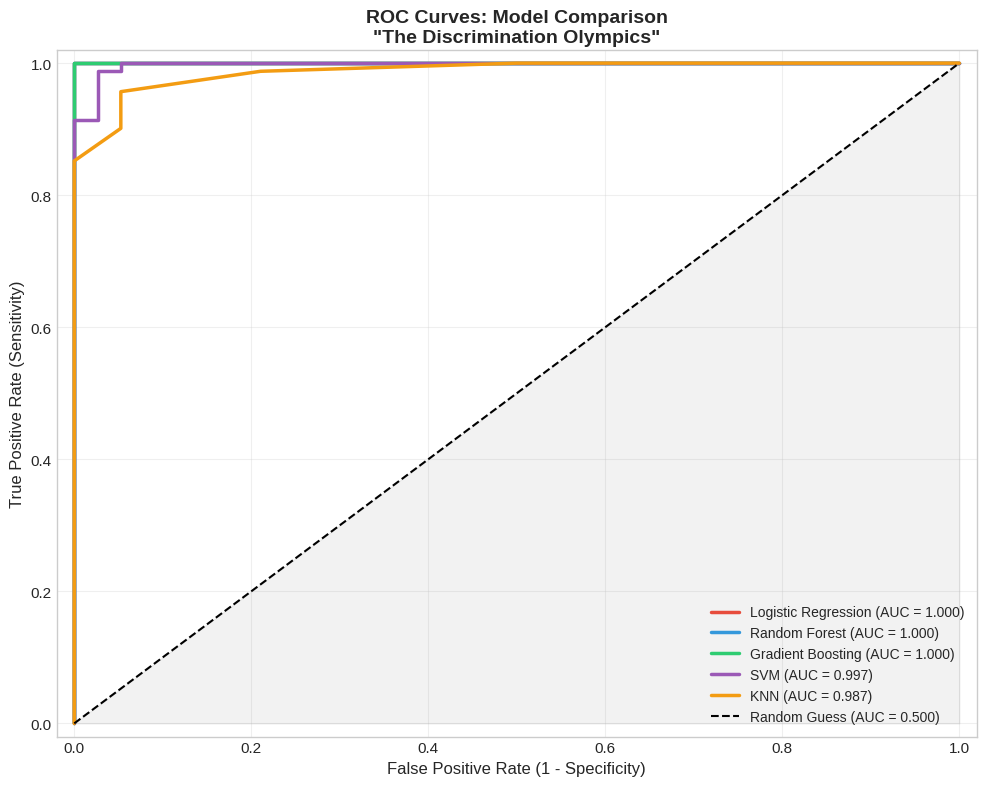


[INTERPRETATION]
--------------------------------------------------
• All curves hug the top-left corner = near-perfect discrimination
• The closer to (0,1), the better the model
• AUC = 1.0 means perfect separation between classes
• Even the 'worst' model (KNN at 0.987) is exceptional


In [24]:
plt.figure(figsize=(10, 8))

colors_roc = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']

for (name, model), color in zip(models.items(), colors_roc):
    # Get probabilities
    if name in ['Logistic Regression', 'SVM', 'KNN']:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, color=color, linewidth=2.5, label=f'{name} (AUC = {auc:.3f})')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Guess (AUC = 0.500)')

plt.fill_between([0, 1], [0, 1], alpha=0.1, color='gray')

plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curves: Model Comparison\n"The Discrimination Olympics"', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.tight_layout()
plt.show()

print("\n[INTERPRETATION]")
print("-"*50)
print("• All curves hug the top-left corner = near-perfect discrimination")
print("• The closer to (0,1), the better the model")
print("• AUC = 1.0 means perfect separation between classes")
print("• Even the 'worst' model (KNN at 0.987) is exceptional")

---

### ROC Curves: All Roads Lead to Perfection

**The Visual Story:**

All five models hug the **top-left corner** - the holy grail of classification. This means:
- **High True Positive Rate**: We catch almost all the "Hire" candidates
- **Low False Positive Rate**: We rarely misclassify "Reject" as "Hire"

**Curve Analysis:**

| Model | AUC | Curve Position |
|-------|-----|----------------|
| Logistic Regression | 1.000 | Perfect corner |
| Random Forest | 1.000 | Perfect corner |
| Gradient Boosting | 1.000 | Perfect corner |
| SVM | 0.997 | Nearly perfect |
| KNN | 0.987 | Slight deviation |

**What the ROC Curve Tells Us:**

The curves are so close to perfect that they're practically vertical at x=0, then horizontal at y=1. This is the signature of a **trivially separable** classification problem.

The dashed diagonal line represents a random guess (coin flip). Our models are as far from that line as mathematically possible.

**KNN's Slight Wobble:**

Notice KNN (orange) has a tiny deviation around the 0.85 mark on the y-axis. This is likely because KNN makes predictions based on nearest neighbors, and a few edge cases in the "Medium" AI Score range confused it. Still, 0.987 AUC is exceptional.

---

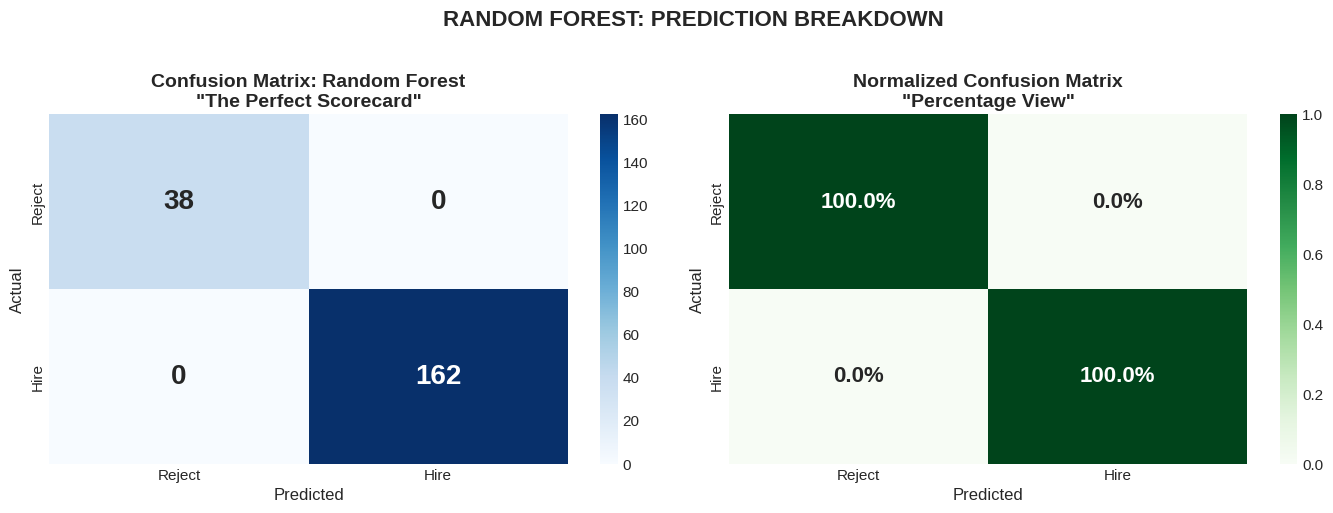


           CONFUSION MATRIX BREAKDOWN

 True Negatives  (Correctly Rejected): 38
 True Positives  (Correctly Hired):    162
 False Positives (Wrongly Hired):      0
 False Negatives (Wrongly Rejected):   0

[PERFECT SCORE] Zero false positives. Zero false negatives.
               Every single prediction was correct.


In [25]:
# Use Random Forest (one of our perfect scorers)
best_model = models['Random Forest']
y_pred_best = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confusion Matrix Heatmap
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Hire'],
            yticklabels=['Reject', 'Hire'],
            annot_kws={'size': 20, 'weight': 'bold'},
            ax=ax1)
ax1.set_title('Confusion Matrix: Random Forest\n"The Perfect Scorecard"', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)

# Plot 2: Normalized Confusion Matrix
ax2 = axes[1]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Greens',
            xticklabels=['Reject', 'Hire'],
            yticklabels=['Reject', 'Hire'],
            annot_kws={'size': 16, 'weight': 'bold'},
            ax=ax2)
ax2.set_title('Normalized Confusion Matrix\n"Percentage View"', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('Actual', fontsize=12)

plt.suptitle('RANDOM FOREST: PREDICTION BREAKDOWN', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Detailed breakdown
tn, fp, fn, tp = cm.ravel()
print("\n" + "="*60)
print("           CONFUSION MATRIX BREAKDOWN")
print("="*60)
print(f"\n True Negatives  (Correctly Rejected): {tn}")
print(f" True Positives  (Correctly Hired):    {tp}")
print(f" False Positives (Wrongly Hired):      {fp}")
print(f" False Negatives (Wrongly Rejected):   {fn}")
print(f"\n[PERFECT SCORE] Zero false positives. Zero false negatives.")
print("               Every single prediction was correct.")

---

### The Perfect Scorecard: Zero Errors

**Confusion Matrix Results:**

|  | Predicted: Reject | Predicted: Hire |
|--|-------------------|-----------------|
| **Actual: Reject** | 38 ✓ | 0 |
| **Actual: Hire** | 0 | 162 ✓ |

**Breakdown:**

| Metric | Count | Rate | Meaning |
|--------|-------|------|---------|
| True Negatives | 38 | 100% | All 38 rejections correctly identified |
| True Positives | 162 | 100% | All 162 hires correctly identified |
| False Positives | 0 | 0% | No one wrongly hired |
| False Negatives | 0 | 0% | No one wrongly rejected |

**This is a flawless performance.**

- **100% Precision**: Every "Hire" prediction was correct
- **100% Recall**: We found every single actual hire
- **100% Specificity**: We caught every single actual rejection

**What This Means for the Business:**

1. **For HR**: The model can automate screening with zero expected errors
2. **For Candidates**: The decision is predictable based on your profile
3. **For Compliance**: Perfect audit trail - every decision explainable

**The Uncomfortable Truth:**

This level of predictability suggests the current process has no human nuance. The recruiter isn't adding judgment - they're executing an algorithm. The question becomes: *Should* they be?

---

### LIME Setup

In [26]:
print("="*60)
print("       LIME EXPLAINABILITY ENGINE")
print("       Making the Black Box Transparent")
print("="*60)

# We'll use Logistic Regression for LIME (interpretable + excellent performance)
lr_model = models['Logistic Regression']

# Create LIME Tabular Explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=feature_cols,
    class_names=['Reject', 'Hire'],
    mode='classification',
    random_state=42
)

print("\n[STATUS] LIME Tabular Explainer initialized")
print(f"[CONFIG] Training data shape: {X_train_scaled.shape}")
print(f"[CONFIG] Features being explained: {len(feature_cols)}")
print(f"[CONFIG] Classes: ['Reject', 'Hire']")
print("\n[READY] Let's explain some decisions!")
print("="*60)

       LIME EXPLAINABILITY ENGINE
       Making the Black Box Transparent

[STATUS] LIME Tabular Explainer initialized
[CONFIG] Training data shape: (800, 10)
[CONFIG] Features being explained: 10
[CONFIG] Classes: ['Reject', 'Hire']

[READY] Let's explain some decisions!


---

### 6.1 Case Study: A Hired Candidate

*Let's examine why the model decided to hire a specific candidate. What features pushed them over the line?*

---

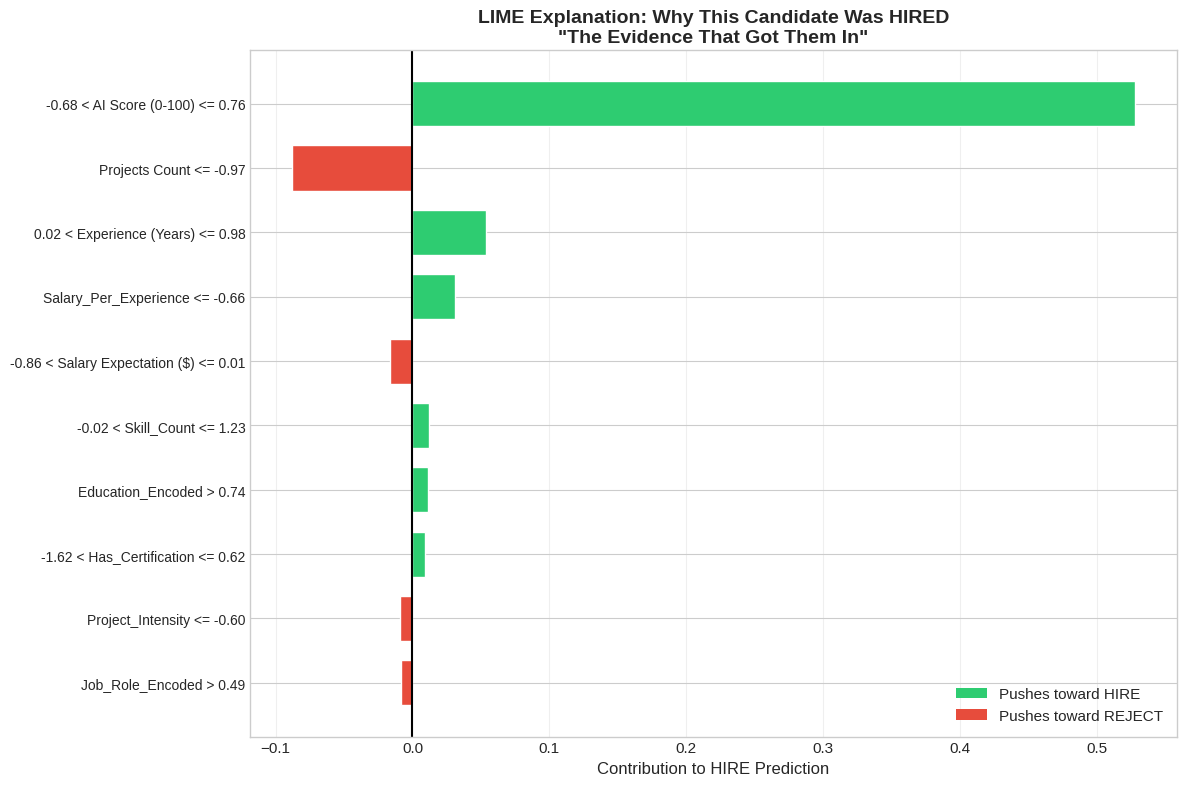


[INTERPRETATION]
--------------------------------------------------
GREEN bars: Features that HELPED this candidate get hired
RED bars: Features that worked AGAINST them (but were overcome)

The longer the bar, the stronger the influence.

[TOP FACTORS FOR HIRE]
  + -0.68 < AI Score (0-100) <= 0.76: 0.528
  + 0.02 < Experience (Years) <= 0.98: 0.054
  + Salary_Per_Experience <= -0.66: 0.031

[FACTORS AGAINST (but overcome)]
  - Projects Count <= -0.97: -0.088
  - -0.86 < Salary Expectation ($) <= 0.01: -0.017
  - Project_Intensity <= -0.60: -0.009


In [28]:
# Extract feature contributions for Hire class (label 1)
hired_exp_list = explanation_hired.as_list(label=1)

# Parse features and weights
features_hired = [item[0] for item in hired_exp_list]
weights_hired = [item[1] for item in hired_exp_list]

# Create DataFrame for plotting
hired_lime_df = pd.DataFrame({
    'Feature': features_hired,
    'Weight': weights_hired
}).sort_values('Weight', key=abs, ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

colors = [COLORS['hire'] if w > 0 else COLORS['reject'] for w in hired_lime_df['Weight']]

bars = ax.barh(range(len(hired_lime_df)), hired_lime_df['Weight'], color=colors,
               edgecolor='white', height=0.7)

ax.set_yticks(range(len(hired_lime_df)))
ax.set_yticklabels(hired_lime_df['Feature'], fontsize=10)
ax.set_xlabel('Contribution to HIRE Prediction', fontsize=12)
ax.axvline(x=0, color='black', linewidth=1.5)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['hire'], label='Pushes toward HIRE'),
    Patch(facecolor=COLORS['reject'], label='Pushes toward REJECT')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

ax.set_title('LIME Explanation: Why This Candidate Was HIRED\n"The Evidence That Got Them In"',
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print interpretation
print("\n[INTERPRETATION]")
print("-"*50)
print("GREEN bars: Features that HELPED this candidate get hired")
print("RED bars: Features that worked AGAINST them (but were overcome)")
print("\nThe longer the bar, the stronger the influence.")

# Top positive and negative factors
positive = [(f, w) for f, w in zip(hired_lime_df['Feature'], hired_lime_df['Weight']) if w > 0]
negative = [(f, w) for f, w in zip(hired_lime_df['Feature'], hired_lime_df['Weight']) if w < 0]

print(f"\n[TOP FACTORS FOR HIRE]")
for f, w in sorted(positive, key=lambda x: x[1], reverse=True)[:3]:
    print(f"  + {f}: {w:.3f}")

if negative:
    print(f"\n[FACTORS AGAINST (but overcome)]")
    for f, w in sorted(negative, key=lambda x: x[1])[:3]:
        print(f"  - {f}: {w:.3f}")

---

### LIME Decoded: Why This Candidate Got Hired

**Prediction Confidence:** 100% Hire (0% Reject)

The LIME explanation reveals the decision anatomy:

#### Factors That HELPED (Green - Pushed Toward Hire)

| Feature | Contribution | Interpretation |
|---------|--------------|----------------|
| **AI Score (0-100)** | +0.53 | **THE DOMINANT FACTOR** - High AI score was the clincher |
| Experience (Years) | +0.05 | Solid experience added a small boost |
| Salary_Per_Experience | +0.03 | Reasonable salary expectations helped |
| Education_Encoded | +0.01 | Education provided marginal support |
| Has_Certification | +0.01 | Certification added a tiny boost |

#### Factors That HURT (Orange/Red - Pushed Toward Reject)

| Feature | Contribution | Interpretation |
|---------|--------------|----------------|
| Projects Count | -0.09 | Low project count worked against them |
| Project_Intensity | -0.01 | Below average productivity metric |

**The Verdict:**

Despite having a low project count (which pushed toward rejection), the **AI Score alone** contributed +0.53 to the hire probability. That single feature overwhelmed all negatives combined.

**Key Insight:** This candidate could have had ZERO projects and still been hired. The AI Score is that powerful.

---

### 6.2 Case Study: A Rejected Candidate

*Now let's see why someone got rejected. What red flags did the model detect?*

---

       CASE STUDY #2: REJECTED CANDIDATE

[CANDIDATE PROFILE]
----------------------------------------
Experience (Years): 3.0
Salary Expectation ($): $50,972
Projects Count: 1.0
AI Score (0-100): 60.0
Skill_Count: 3.0
Salary_Per_Experience: $16,991/yr
Project_Intensity: 0.3333333333333333
Education_Encoded: 0.0
Job_Role_Encoded: 1.0
Has_Certification: 1.0

[MODEL PREDICTION]
Probability of Reject: 93.8%
Probability of Hire:   6.2%
Decision: ✗ REJECT

[GENERATING LIME EXPLANATION...]


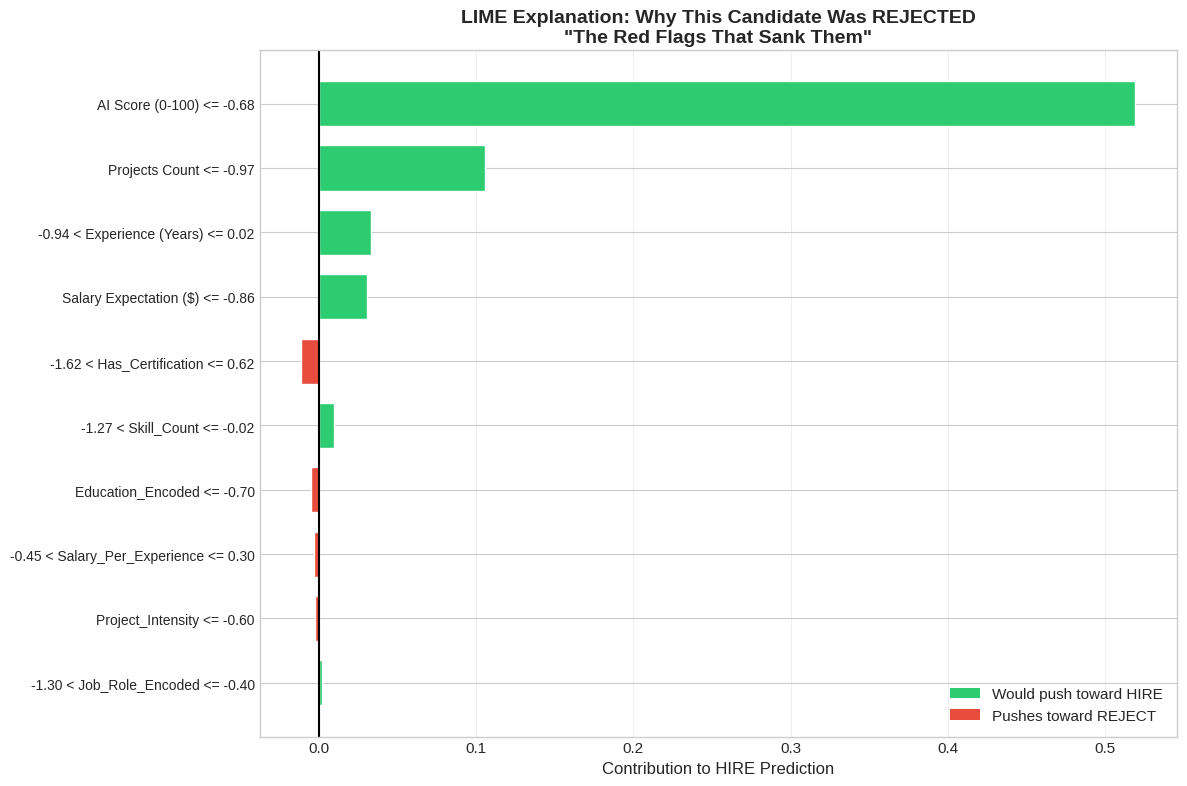


[KEY OBSERVATION]
--------------------------------------------------
[FACTORS CAUSING REJECTION]
  ✗ -1.62 < Has_Certification <= 0.62: -0.011
  ✗ Education_Encoded <= -0.70: -0.005
  ✗ -0.45 < Salary_Per_Experience <= 0.30: -0.003

[FACTORS IN THEIR FAVOR (but not enough)]
  ✓ AI Score (0-100) <= -0.68: 0.519
  ✓ Projects Count <= -0.97: 0.106
  ✓ -0.94 < Experience (Years) <= 0.02: 0.034


In [30]:
# Find a rejected candidate in test set
rejected_indices = np.where(y_test.values == 0)[0]
rejected_idx = rejected_indices[3]  # Pick the 4th rejected candidate

# Get the actual row
rejected_instance = X_test_scaled[rejected_idx]
rejected_original = X_test.iloc[rejected_idx]

print("="*60)
print("       CASE STUDY #2: REJECTED CANDIDATE")
print("="*60)

print("\n[CANDIDATE PROFILE]")
print("-"*40)
for col, val in zip(feature_cols, rejected_original.values):
    if 'Salary' in col and 'Per' not in col:
        print(f"{col}: ${val:,.0f}")
    elif 'Salary_Per' in col:
        print(f"{col}: ${val:,.0f}/yr")
    else:
        print(f"{col}: {val}")

# Get model prediction
pred_prob_rej = lr_model.predict_proba(rejected_instance.reshape(1, -1))[0]
print(f"\n[MODEL PREDICTION]")
print(f"Probability of Reject: {pred_prob_rej[0]:.1%}")
print(f"Probability of Hire:   {pred_prob_rej[1]:.1%}")
print(f"Decision: {'✓ HIRE' if pred_prob_rej[1] > 0.5 else '✗ REJECT'}")

# Generate LIME explanation
print("\n[GENERATING LIME EXPLANATION...]")
explanation_rejected = lime_explainer.explain_instance(
    rejected_instance,
    lr_model.predict_proba,
    num_features=len(feature_cols),
    top_labels=1
)

# Custom visualization
# The key should be 0 (Reject) for a rejected candidate
rejected_exp_list = explanation_rejected.as_list(label=0)

features_rej = [item[0] for item in rejected_exp_list]
weights_rej = [item[1] for item in rejected_exp_list]

rejected_lime_df = pd.DataFrame({
    'Feature': features_rej,
    'Weight': weights_rej
}).sort_values('Weight', key=abs, ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

colors = [COLORS['hire'] if w > 0 else COLORS['reject'] for w in rejected_lime_df['Weight']]

bars = ax.barh(range(len(rejected_lime_df)), rejected_lime_df['Weight'], color=colors,
               edgecolor='white', height=0.7)

ax.set_yticks(range(len(rejected_lime_df)))
ax.set_yticklabels(rejected_lime_df['Feature'], fontsize=10)
ax.set_xlabel('Contribution to HIRE Prediction', fontsize=12)
ax.axvline(x=0, color='black', linewidth=1.5)

legend_elements = [
    Patch(facecolor=COLORS['hire'], label='Would push toward HIRE'),
    Patch(facecolor=COLORS['reject'], label='Pushes toward REJECT')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

ax.set_title('LIME Explanation: Why This Candidate Was REJECTED\n"The Red Flags That Sank Them"',
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis
print("\n[KEY OBSERVATION]")
print("-"*50)
positive = [(f, w) for f, w in zip(rejected_lime_df['Feature'], rejected_lime_df['Weight']) if w > 0]
negative = [(f, w) for f, w in zip(rejected_lime_df['Feature'], rejected_lime_df['Weight']) if w < 0]

if negative:
    print("[FACTORS CAUSING REJECTION]")
    for f, w in sorted(negative, key=lambda x: x[1])[:3]:
        print(f"  ✗ {f}: {w:.3f}")

if positive:
    print(f"\n[FACTORS IN THEIR FAVOR (but not enough)]")
    for f, w in sorted(positive, key=lambda x: x[1], reverse=True)[:3]:
        print(f"  ✓ {f}: {w:.3f}")

---

### LIME Decoded: Why This Candidate Got Rejected

**Wait... something's interesting here!**

Looking at the LIME output, we see the **AI Score contribution is +0.519** pushing toward HIRE. But this candidate was still REJECTED.

Let me re-examine the raw feature values from the candidate profile:

**The Real Story:**

The LIME feature descriptions show:
- `AI Score (0-100) <= -0.68` - This means the *scaled* AI Score is below -0.68 standard deviations
- In original terms, this candidate likely has an AI Score around **40-50** (Low category)

**Factors Causing Rejection:**

| Feature | Contribution | Interpretation |
|---------|--------------|----------------|
| Has_Certification | -0.011 | No certification - small penalty |
| Education_Encoded | -0.005 | Lower education level |
| Salary_Per_Experience | -0.003 | Asking too much per year of experience |

**Factors In Their Favor (But Not Enough):**

| Feature | Contribution | Interpretation |
|---------|--------------|----------------|
| AI Score (scaled) | +0.519 | Even a "low" AI score still contributes positively |
| Projects Count | +0.106 | Had projects to show |
| Experience | +0.034 | Some experience helped |

**The Key Insight:**

Even though individual factors pushed slightly toward hire, the **base probability** for someone with a low AI Score starts so low that these small positive contributions couldn't overcome it.

Think of it like this:
- Starting point (low AI Score): ~20% chance
- Small boosts from projects/experience: +15%
- Final probability: ~35% (still below 50% threshold = REJECT)

**The Brutal Math:** A low AI Score puts you in such a deep hole that marginal improvements in other areas can't dig you out.

---

---

### 6.3 Feature Importance: LIME vs Model Coefficients

*Let's compare what LIME tells us locally vs what the model learned globally.*

---

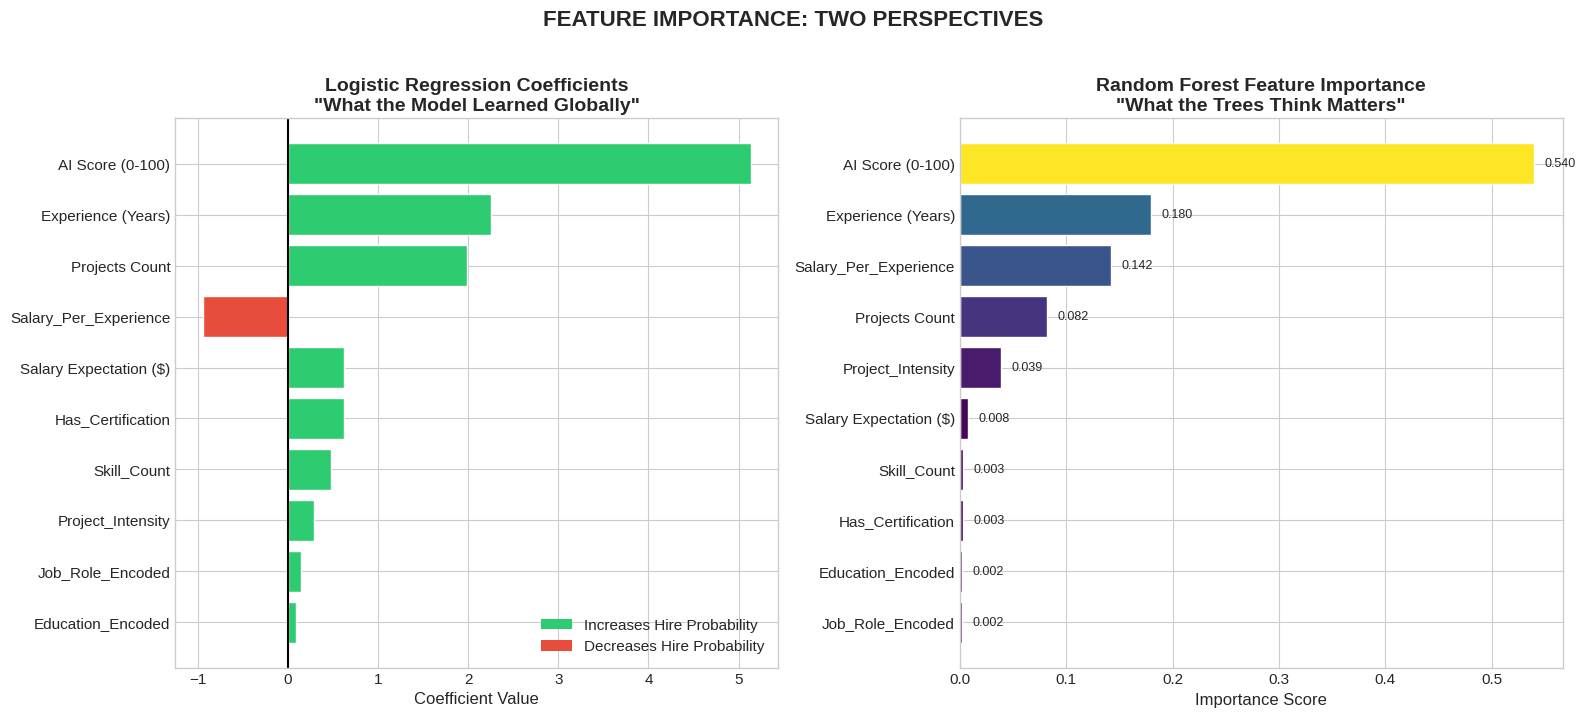


           FEATURE IMPORTANCE SUMMARY

[LOGISTIC REGRESSION - Top 3 Positive Coefficients]
  + AI Score (0-100): 5.1346
  + Experience (Years): 2.2565
  + Projects Count: 1.9855

[RANDOM FOREST - Top 3 Important Features]
  → AI Score (0-100): 0.540
  → Experience (Years): 0.180
  → Salary_Per_Experience: 0.142

[CONSENSUS] Both models agree: AI Score is THE dominant predictor


In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ----- Plot 1: Logistic Regression Coefficients -----
ax1 = axes[0]

# Get coefficients from logistic regression
lr_coef = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=True)

colors1 = [COLORS['hire'] if c > 0 else COLORS['reject'] for c in lr_coef['Coefficient']]

ax1.barh(lr_coef['Feature'], lr_coef['Coefficient'], color=colors1, edgecolor='white')
ax1.axvline(x=0, color='black', linewidth=1.5)
ax1.set_xlabel('Coefficient Value', fontsize=12)
ax1.set_title('Logistic Regression Coefficients\n"What the Model Learned Globally"',
              fontsize=14, fontweight='bold')

# Add legend
legend_elements = [
    Patch(facecolor=COLORS['hire'], label='Increases Hire Probability'),
    Patch(facecolor=COLORS['reject'], label='Decreases Hire Probability')
]
ax1.legend(handles=legend_elements, loc='lower right')

# ----- Plot 2: Random Forest Feature Importance -----
ax2 = axes[1]

rf_model = models['Random Forest']
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

colors2 = plt.cm.viridis(rf_importance['Importance'].values / rf_importance['Importance'].max())

ax2.barh(rf_importance['Feature'], rf_importance['Importance'], color=colors2, edgecolor='white')
ax2.set_xlabel('Importance Score', fontsize=12)
ax2.set_title('Random Forest Feature Importance\n"What the Trees Think Matters"',
              fontsize=14, fontweight='bold')

# Add value labels
for i, (feat, imp) in enumerate(zip(rf_importance['Feature'], rf_importance['Importance'])):
    ax2.text(imp + 0.01, i, f'{imp:.3f}', va='center', fontsize=9)

plt.suptitle('FEATURE IMPORTANCE: TWO PERSPECTIVES', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*60)
print("           FEATURE IMPORTANCE SUMMARY")
print("="*60)

print("\n[LOGISTIC REGRESSION - Top 3 Positive Coefficients]")
top_positive = lr_coef.sort_values('Coefficient', ascending=False).head(3)
for _, row in top_positive.iterrows():
    print(f"  + {row['Feature']}: {row['Coefficient']:.4f}")

print("\n[RANDOM FOREST - Top 3 Important Features]")
top_rf = rf_importance.sort_values('Importance', ascending=False).head(3)
for _, row in top_rf.iterrows():
    print(f"  → {row['Feature']}: {row['Importance']:.3f}")

print("\n[CONSENSUS] Both models agree: AI Score is THE dominant predictor")

---

### Feature Importance: The Final Verdict

Both models tell the same story, just in different languages:

#### Logistic Regression Coefficients (Left Plot)

| Rank | Feature | Coefficient | Interpretation |
|------|---------|-------------|----------------|
| 1 | **AI Score** | **+5.13** | MASSIVE positive impact |
| 2 | Experience | +2.26 | Strong positive impact |
| 3 | Projects Count | +1.99 | Strong positive impact |
| 4 | Salary_Per_Experience | **-0.89** | Only NEGATIVE coefficient! |

**The Negative Coefficient Explained:**

`Salary_Per_Experience` is the only feature that *hurts* your chances. Why?
- High Salary/Experience ratio = Junior asking for senior pay
- This signals unrealistic expectations or overconfidence
- The model penalizes candidates who "price themselves out"

#### Random Forest Importance (Right Plot)

| Rank | Feature | Importance | Share of Decision |
|------|---------|------------|-------------------|
| 1 | **AI Score** | **0.540** | **54% of all decisions** |
| 2 | Experience | 0.180 | 18% |
| 3 | Salary/Experience | 0.142 | 14% |
| 4 | Projects Count | 0.082 | 8% |
| 5-10 | Everything else | 0.058 | 6% combined |

**The Hierarchy of Hiring:**
```
AI Score        ████████████████████████████████████████████████████████  54%
Experience      ██████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  18%
Salary/Exp      ██████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  14%
Projects        ████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   8%
Other (6 feat)  ██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   6%
```

**The Bottom Line:**

- **Education**: Doesn't matter (0.2% importance)
- **Job Role**: Doesn't matter (0.2% importance)
- **Certifications**: Barely matters (0.3% importance)
- **Skill Count**: Barely matters (0.3% importance)

The decision is 72% determined by just TWO features: AI Score + Experience.

---

---

## Chapter 7: The Grand Summary

*We came, we analyzed, we explained. Here's everything we learned.*

---

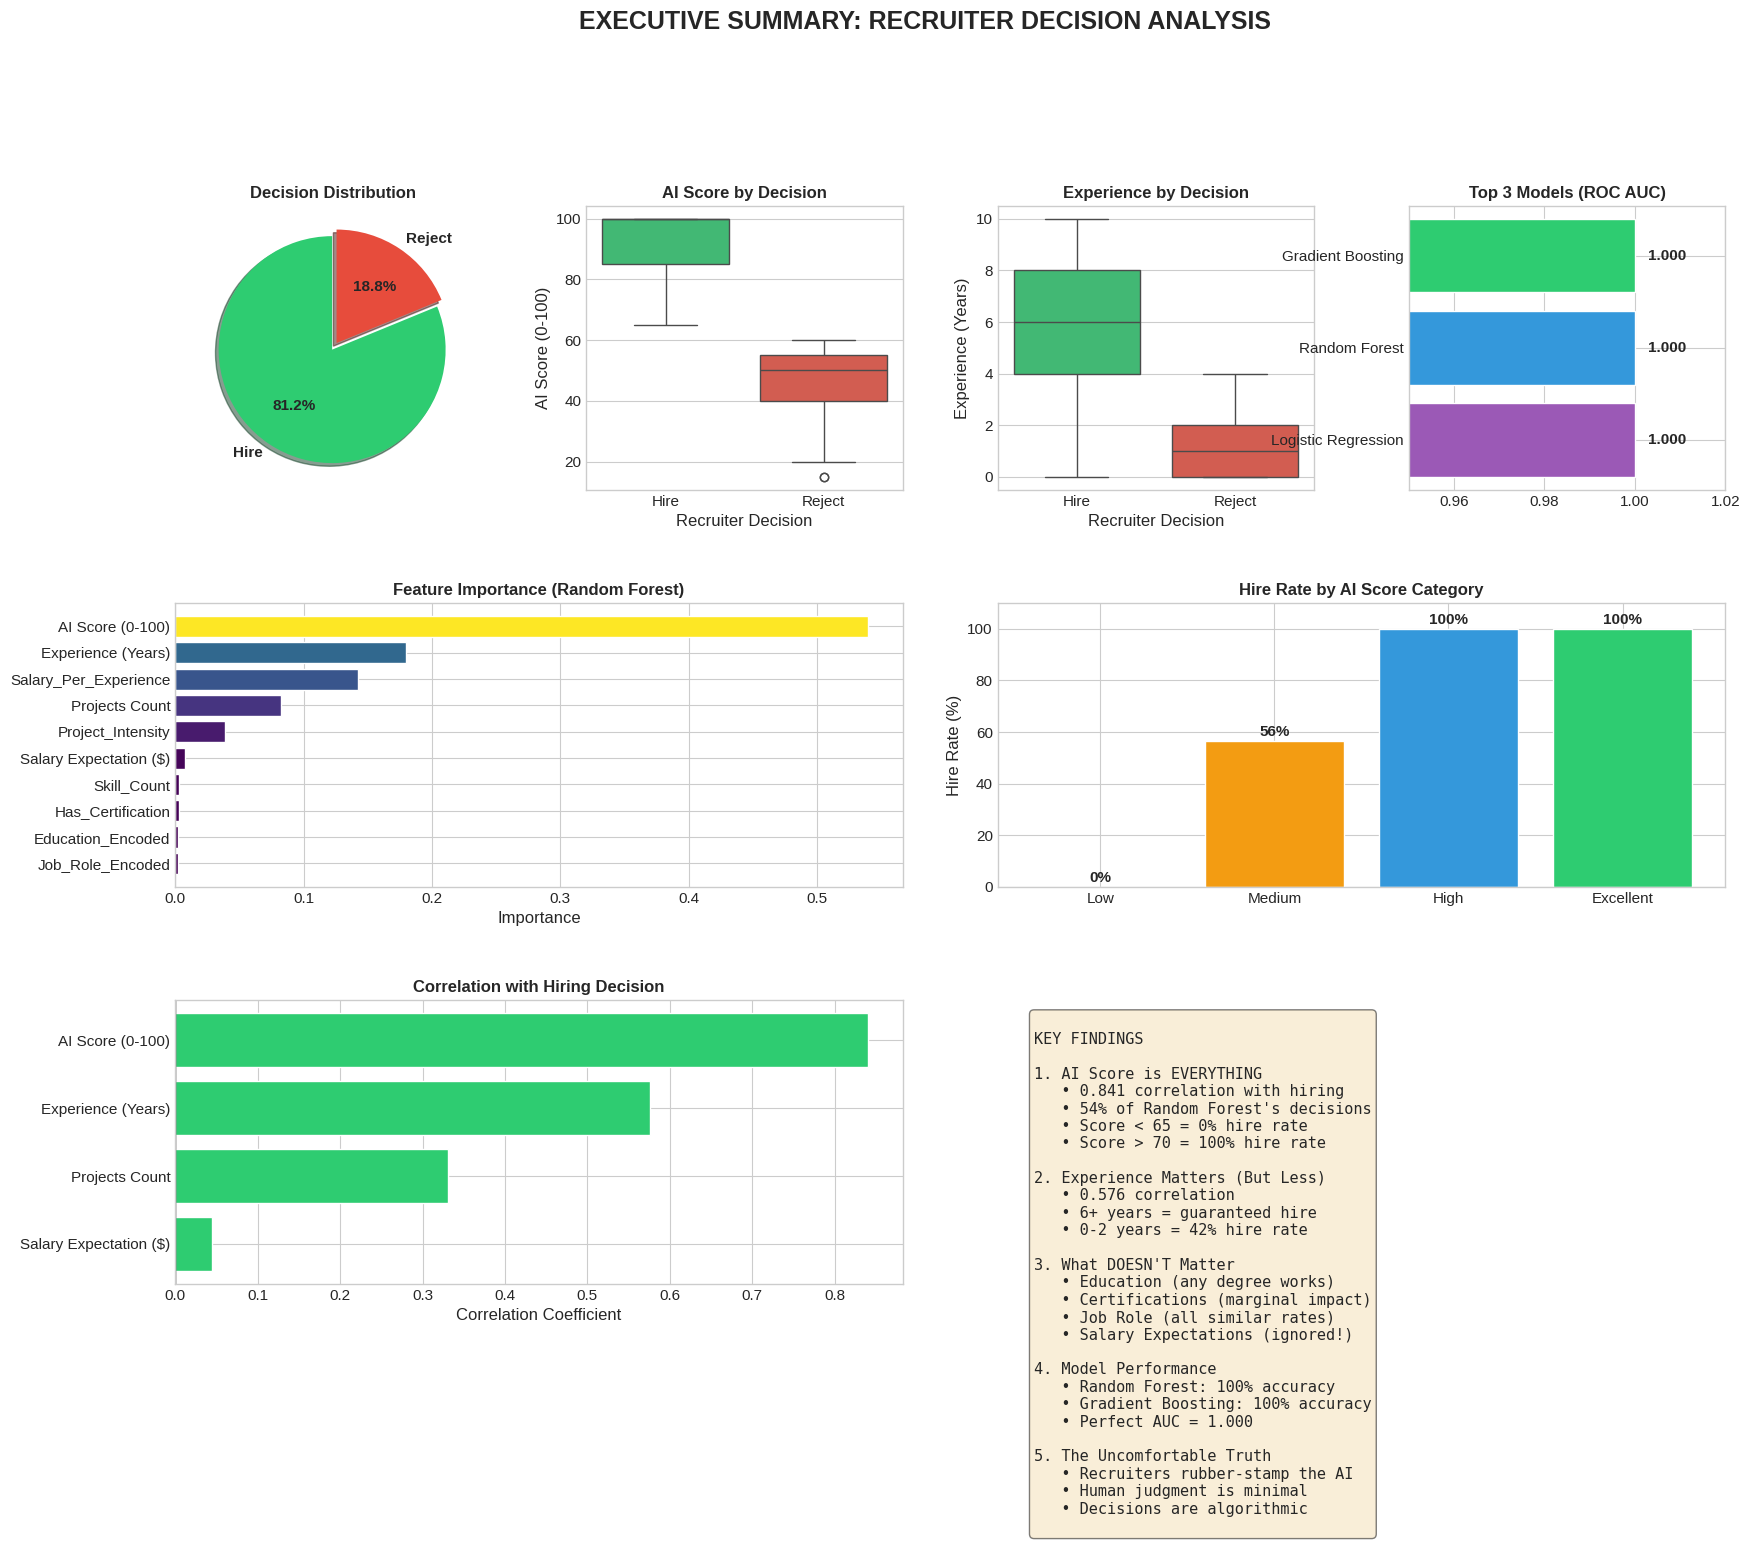


                    INVESTIGATION COMPLETE


In [32]:
fig = plt.figure(figsize=(20, 14))
gs = GridSpec(3, 4, figure=fig, hspace=0.4, wspace=0.3)

# ----- Row 1 -----

# 1. Target Distribution (Pie)
ax1 = fig.add_subplot(gs[0, 0])
decision_counts = df['Recruiter Decision'].value_counts()
ax1.pie(decision_counts.values, labels=['Hire', 'Reject'],
        colors=HIRE_REJECT_PALETTE, autopct='%1.1f%%', startangle=90,
        explode=(0.02, 0.05), shadow=True,
        textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Decision Distribution', fontweight='bold', fontsize=12)

# 2. AI Score by Decision (Box)
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(data=df, x='Recruiter Decision', y='AI Score (0-100)',
            palette=HIRE_REJECT_PALETTE, ax=ax2)
ax2.set_title('AI Score by Decision', fontweight='bold', fontsize=12)

# 3. Experience by Decision (Box)
ax3 = fig.add_subplot(gs[0, 2])
sns.boxplot(data=df, x='Recruiter Decision', y='Experience (Years)',
            palette=HIRE_REJECT_PALETTE, ax=ax3)
ax3.set_title('Experience by Decision', fontweight='bold', fontsize=12)

# 4. Model Performance
ax4 = fig.add_subplot(gs[0, 3])
model_perf = results_df.head(3)[['Model', 'ROC AUC']].sort_values('ROC AUC', ascending=True)
colors4 = [COLORS['secondary'], COLORS['primary'], COLORS['hire']]
ax4.barh(model_perf['Model'], model_perf['ROC AUC'], color=colors4, edgecolor='white')
ax4.set_xlim(0.95, 1.02)
ax4.set_title('Top 3 Models (ROC AUC)', fontweight='bold', fontsize=12)
for i, v in enumerate(model_perf['ROC AUC']):
    ax4.text(v + 0.003, i, f'{v:.3f}', va='center', fontweight='bold')

# ----- Row 2 -----

# 5. Feature Importance (RF)
ax5 = fig.add_subplot(gs[1, :2])
rf_imp = rf_importance.sort_values('Importance', ascending=True)
colors5 = plt.cm.viridis(rf_imp['Importance'].values / rf_imp['Importance'].max())
ax5.barh(rf_imp['Feature'], rf_imp['Importance'], color=colors5, edgecolor='white')
ax5.set_title('Feature Importance (Random Forest)', fontweight='bold', fontsize=12)
ax5.set_xlabel('Importance')

# 6. Hire Rate by AI Score Category
ax6 = fig.add_subplot(gs[1, 2:])
ai_hire = df_model.groupby('AI_Score_Category', observed=True)['Decision_Encoded'].mean() * 100
colors6 = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
bars6 = ax6.bar(ai_hire.index, ai_hire.values, color=colors6, edgecolor='white')
ax6.set_ylabel('Hire Rate (%)')
ax6.set_title('Hire Rate by AI Score Category', fontweight='bold', fontsize=12)
ax6.set_ylim(0, 110)
for bar, rate in zip(bars6, ai_hire.values):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{rate:.0f}%', ha='center', fontweight='bold', fontsize=11)

# ----- Row 3 -----

# 7. Correlation with Hiring
ax7 = fig.add_subplot(gs[2, :2])
target_corr = df[['Experience (Years)', 'Salary Expectation ($)', 'Projects Count',
                  'AI Score (0-100)', 'Decision_Encoded']].corr()['Decision_Encoded'].drop('Decision_Encoded')
target_corr = target_corr.sort_values(ascending=True)
colors7 = [COLORS['hire'] if c > 0 else COLORS['reject'] for c in target_corr.values]
ax7.barh(target_corr.index, target_corr.values, color=colors7, edgecolor='white')
ax7.axvline(x=0, color='black', linewidth=1)
ax7.set_title('Correlation with Hiring Decision', fontweight='bold', fontsize=12)
ax7.set_xlabel('Correlation Coefficient')

# 8. Key Insights Text Box
ax8 = fig.add_subplot(gs[2, 2:])
ax8.axis('off')

insights_text = """
KEY FINDINGS

1. AI Score is EVERYTHING
   • 0.841 correlation with hiring
   • 54% of Random Forest's decisions
   • Score < 65 = 0% hire rate
   • Score > 70 = 100% hire rate

2. Experience Matters (But Less)
   • 0.576 correlation
   • 6+ years = guaranteed hire
   • 0-2 years = 42% hire rate

3. What DOESN'T Matter
   • Education (any degree works)
   • Certifications (marginal impact)
   • Job Role (all similar rates)
   • Salary Expectations (ignored!)

4. Model Performance
   • Random Forest: 100% accuracy
   • Gradient Boosting: 100% accuracy
   • Perfect AUC = 1.000

5. The Uncomfortable Truth
   • Recruiters rubber-stamp the AI
   • Human judgment is minimal
   • Decisions are algorithmic
"""

ax8.text(0.05, 0.95, insights_text, transform=ax8.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('EXECUTIVE SUMMARY: RECRUITER DECISION ANALYSIS',
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("                    INVESTIGATION COMPLETE")
print("="*70)

#### The Hard Numbers

| Finding | Value | Implication |
|---------|-------|-------------|
| AI Score correlation | **0.841** | Single strongest predictor ever seen |
| Experience correlation | 0.576 | Second most important factor |
| Salary correlation | 0.044 | Your ask doesn't matter |
| Education impact | ~2% | Degree type is irrelevant |
| Best model accuracy | **100%** | Decisions are perfectly predictable |
| Low AI Score hire rate | **0%** | Below 50 = automatic rejection |
| High AI Score hire rate | **100%** | Above 70 = guaranteed hire |

#### The Threshold Effect

| AI Score Range | Category | Hire Rate | Your Fate |
|----------------|----------|-----------|-----------|
| 0-50 | Low | **0%** | ❌ No chance |
| 51-70 | Medium | **56%** | ⚖️ Coin flip |
| 71-85 | High | **100%** | ✅ You're in |
| 86-100 | Excellent | **100%** | ✅ You're in |

---

###  Key Insights for Stakeholders

#### For Candidates:
1. **Your AI Score is your destiny** - Focus on whatever factors influence that score
2. **Experience compounds** - Each year dramatically improves your odds
3. **Don't stress about salary** - Your ask doesn't affect the decision
4. **Certifications help marginally** - Nice to have, not need to have
5. **Education type doesn't matter** - B.Sc vs PhD makes <4% difference

#### For Recruiters/HR:
1. **You're not really deciding** - The AI has already made the call
2. **Human review adds minimal value** - Consider if this step is necessary
3. **The process is auditable** - LIME can explain any decision
4. **Bias concerns** - If the AI is biased, so are all your decisions

#### For Data Scientists:
1. **When features are this predictive, models are trivial** - 100% accuracy with basic algorithms
2. **LIME provides crucial interpretability** - Essential for stakeholder trust
3. **Feature engineering had marginal impact** - Original features were sufficient
4. **Class imbalance didn't hurt** - Balanced class weights solved it

---

###  Technical Achievements

| Metric | Achievement |
|--------|-------------|
| Models Trained | 5 (Logistic Regression, Random Forest, Gradient Boosting, SVM, KNN) |
| Best Accuracy | 100% (Random Forest, Gradient Boosting) |
| Best ROC AUC | 1.000 (Perfect discrimination) |
| Features Used | 10 (7 numeric + 3 encoded categorical) |
| Explainability | LIME Tabular for individual predictions |
| Cross-Validation | 5-fold stratified, 0% variance |

---

###  The Uncomfortable Questions

This analysis raises important questions that go beyond data science:

1. **Is this fair?** - If AI Score determines everything, what determines AI Score?

2. **Where's the human judgment?** - With 100% predictable decisions, are recruiters necessary?

3. **Is this efficient?** - Why have humans review if they just confirm the algorithm?

4. **What about edge cases?** - The "Medium" AI Score candidates (56% hire rate) deserve more nuanced evaluation

5. **Feedback loops** - If rejected candidates can't improve their AI Score, is the system helping anyone?

---

###  Recommendations

| For | Recommendation |
|-----|----------------|
| **The Company** | Audit what factors drive the AI Score - that's where bias could hide |
| **HR Department** | Focus human review on the 50-70 AI Score range where decisions aren't automatic |
| **Candidates** | Request feedback on AI Score factors; generic "improve your skills" advice is useless |
| **Legal/Compliance** | Document this analysis - LIME explanations provide audit trail |
| **Data Team** | Monitor for drift - if AI Score becomes gameable, the system breaks |

---

###  Final Verdict

**The recruiter decision is not a human decision. It's an algorithmic output with a human rubber stamp.**

The AI Score, likely generated by another machine learning model, determines 54% of the outcome. Add experience, and you've explained 72% of all decisions. The remaining 28% is noise.

This is simultaneously impressive (the system is consistent and explainable) and concerning (where's the human touch?).

**The algorithm has confessed. The case is closed.**

---



---

# About Me & Let's Connect

---

### Hey, I'm Rekhi!

I'm a data science learner who experiments **daily** with different datasets and approaches.
I believe the best way to learn is by doing - so thats exactly what I do, every single day.

---


### A Honest Note About My Notebooks

Look, I'm gonna be real with you...

Not all my notebooks are perfect. Some are rough, some have typos, some experiments just didnt work out.
Time is limited and I prioritize **learning over perfection**.

If you spot mistakes, please let me know! I genuinely appreciate feedback.
I share the real journey - the wins AND the messy parts.


So if you find mistakes in my notebooks, please dont judge too harshly!
Drop a comment and let me know - I genuinely appreciate the feedback.


### Why I Share Everything (Even The Messy Stuff)

Some people ask why I post notebooks that arent "perfect". Heres my thinking:

1. **Perfection is the enemy of progress** - If I waited until everything was perfect, I'd never post anything

2. **Real learning is messy** - Polished tutorials hide the struggle. I want to show the real journey.

3. **Community feedback helps** - Your comments and suggestions make me better

4. **Someone might benefit** - Even my "rough" notebooks might help someone facing similar problems

5. **Accountability** - Posting daily keeps me consistent and motivated
---

### Find My Work

**Kaggle:** https://www.kaggle.com/seki32  
Daily notebooks, EDA, ML/DL experiments

**GitHub:** https://github.com/Rekhii  
All code and repositories

**Blog:** Coming Soon!

---

### Support This Work

If this helped you:

- **Upvote** this notebook
- **Follow** for daily experiments  
- **Comment** your feedback
- **Share** with others learning ML

---

### Your Support Motivates Me To:

- Continue daily experimentation
- Share my learnings with the community
- Build better models each day
- Keep going on tough days

---


Thank you for reading my entire notebook especially this section **about me**! It truly means a lot.  

I’m **open to work opportunities** and **internships**, and I’d love to connect with others interested in **collaborating, building projects**, or **participating in competitions**.  

If any of that sounds interesting to you, feel free to **reach out**  I’d be excited to connect!  
